In [2]:
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns

import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from sklearn.metrics import mean_squared_error
import math

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.pylab import rcParams
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from time import time

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm

sns.set(rc={'figure.figsize':(8,6)})

zillow_data = pd.read_csv('zillow_data.csv')
zillow_data.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


### Introduction
In this analysis I will be looking into NJ, specifiically husdson county, to find the best locations within this county to invest in. 

In [3]:
NJ_Hudson_zd = zillow_data.loc[(zillow_data.State == 'NJ')&(zillow_data.CountyName == 'Hudson')]
NJ_Hudson_zd.head(15)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
57,60545,7030,Hoboken,NJ,New York,Hudson,58,301600.0,302700.0,303800.0,...,1789100,1803000,1818100,1836900,1850100,1853500,1852200,1854400,1857600,1854300
187,60518,7002,Bayonne,NJ,New York,Hudson,188,145000.0,144500.0,143900.0,...,318500,324100,330900,339000,347400,352800,355900,361500,368700,372900
191,60639,7302,Jersey City,NJ,New York,Hudson,192,137200.0,137800.0,138500.0,...,1340200,1372300,1411000,1435900,1446300,1447800,1454900,1453900,1439500,1427300
214,60599,7093,West New York,NJ,New York,Hudson,215,131700.0,131900.0,132100.0,...,361200,368200,376800,386200,392900,395100,395500,399400,407000,412700
319,60594,7087,Union City,NJ,New York,Hudson,320,127300.0,127000.0,126700.0,...,367000,377500,386000,394700,403700,410500,415500,424000,437400,448900
519,60642,7305,Jersey City,NJ,New York,Hudson,520,105200.0,104500.0,103800.0,...,228000,231200,234600,241100,251100,261600,268600,276000,286700,295100
546,60560,7047,North Bergen,NJ,New York,Hudson,547,147200.0,146800.0,146400.0,...,365100,366200,368300,374100,383300,389900,391200,396500,409200,419100
660,60643,7306,Jersey City,NJ,New York,Hudson,661,111400.0,111100.0,110900.0,...,465400,469800,475900,484000,495800,506700,510000,515300,531900,545500
1737,60644,7307,Jersey City,NJ,New York,Hudson,1738,114300.0,114300.0,114400.0,...,439500,449000,458300,468100,478200,487300,496000,510600,531900,546600
2989,60547,7032,Kearny,NJ,New York,Hudson,2990,150300.0,150200.0,150100.0,...,307800,311900,316300,321800,327100,331300,334900,338100,341300,343200


In [4]:
NJ_Hudson_zd = NJ_Hudson_zd.drop(['RegionID','State','Metro','CountyName','SizeRank'],axis=1)

In [5]:
NJ_Hudson_zd

,RegionName,City,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
57,7030,Hoboken,301600.0,302700.0,303800.0,304800.0,305800.0,306800.0,308100.0,309400.0,...,1789100,1803000,1818100,1836900,1850100,1853500,1852200,1854400,1857600,1854300
187,7002,Bayonne,145000.0,144500.0,143900.0,143300.0,142800.0,142400.0,142100.0,142000.0,...,318500,324100,330900,339000,347400,352800,355900,361500,368700,372900
191,7302,Jersey City,137200.0,137800.0,138500.0,139100.0,139600.0,140100.0,140700.0,141400.0,...,1340200,1372300,1411000,1435900,1446300,1447800,1454900,1453900,1439500,1427300
214,7093,West New York,131700.0,131900.0,132100.0,132300.0,132500.0,132700.0,133000.0,133500.0,...,361200,368200,376800,386200,392900,395100,395500,399400,407000,412700
319,7087,Union City,127300.0,127000.0,126700.0,126400.0,126100.0,125900.0,125800.0,125800.0,...,367000,377500,386000,394700,403700,410500,415500,424000,437400,448900
519,7305,Jersey City,105200.0,104500.0,103800.0,103100.0,102600.0,102100.0,101800.0,101700.0,...,228000,231200,234600,241100,251100,261600,268600,276000,286700,295100
546,7047,North Bergen,147200.0,146800.0,146400.0,146000.0,145800.0,145800.0,146100.0,146600.0,...,365100,366200,368300,374100,383300,389900,391200,396500,409200,419100
660,7306,Jersey City,111400.0,111100.0,110900.0,110600.0,110300.0,110000.0,109700.0,109400.0,...,465400,469800,475900,484000,495800,506700,510000,515300,531900,545500
1737,7307,Jersey City,114300.0,114300.0,114400.0,114500.0,114800.0,115200.0,115700.0,116300.0,...,439500,449000,458300,468100,478200,487300,496000,510600,531900,546600
2989,7032,Kearny,150300.0,150200.0,150100.0,150200.0,150200.0,150400.0,150600.0,150900.0,...,307800,311900,316300,321800,327100,331300,334900,338100,341300,343200


In [6]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

In [7]:
df_time = get_datetimes(NJ_Hudson_zd.iloc[:,2::])
df_time

DatetimeIndex(['1996-05-01', '1996-06-01', '1996-07-01', '1996-08-01',
               '1996-09-01', '1996-10-01', '1996-11-01', '1996-12-01',
               '1997-01-01', '1997-02-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=264, freq=None)

In [8]:
def melt_data(df):
    #id_vars keeps all columns you want to remain intake, var_name
    melted = pd.melt(df, id_vars=['RegionName', 'City'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [9]:
NJ_HUDSON_zd = melt_data(NJ_Hudson_zd).set_index('time')

In [10]:
NJ_HUDSON_zd[NJ_HUDSON_zd.RegionName == 7093].asfreq('MS')

,RegionName,City,value
time,,,
1996-04-01,7093,West New York,131700.0
1996-05-01,7093,West New York,131900.0
1996-06-01,7093,West New York,132100.0
1996-07-01,7093,West New York,132300.0
1996-08-01,7093,West New York,132500.0
...,...,...,...
2017-12-01,7093,West New York,395100.0
2018-01-01,7093,West New York,395500.0
2018-02-01,7093,West New York,399400.0


In [11]:
df_NJ_HudsonZC = []
for zc in NJ_HUDSON_zd.RegionName.unique():
    #Create seperate df for each zipcodes with a monthly fq
    df = NJ_HUDSON_zd[NJ_HUDSON_zd.RegionName == zc].asfreq('MS')
    df_NJ_HudsonZC.append(df)

In [12]:
len(df_NJ_HudsonZC)

13

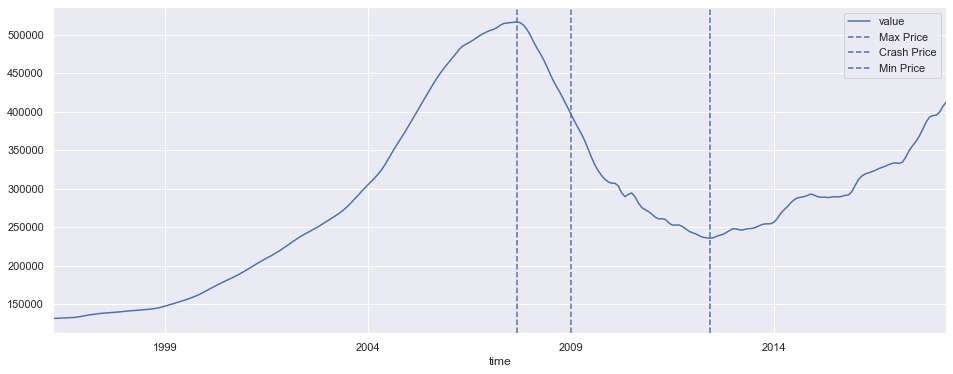

In [13]:
## Will locate the time before the housing market crash, the max value of homes in WNY
maxid = df_NJ_HudsonZC[3]['value'].loc['2004':'2010'].idxmax()
minid = df_NJ_HudsonZC[3]['value'].loc['2010':'2018'].idxmin()
## Will also show the time of the recorded housig market crash
crash = '01-2009'
## Plot the Average home values for WNY, with indicators for the max, market crash, and min
df_NJ_HudsonZC[3]['value'].plot(figsize= (16,6))

plt.axvline(maxid, label='Max Price', ls='--')
plt.axvline(crash, label='Crash Price', ls='--' )
plt.axvline(minid, label='Min Price', ls='--' )

plt.legend()

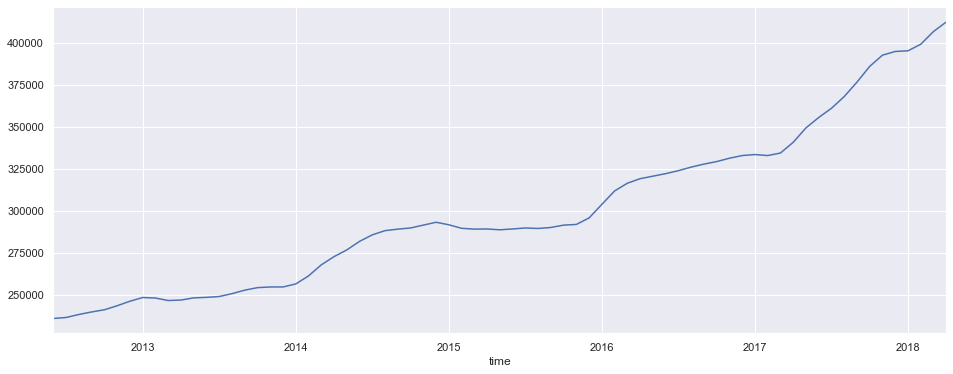

In [14]:
start = datetime(2012,6,1)
df_NJ_HudsonZC[3][start:]['value'].plot(figsize=(16,6))

In [15]:
list_RegionName = []
list_zip = NJ_HUDSON_zd.RegionName.unique().tolist()
for i in range(len(list_zip)):
    RegionName = NJ_Hudson_zd.loc[NJ_Hudson_zd.RegionName == list_zip[i]].City
    list_RegionName.append(RegionName.reset_index(drop=True)[0])

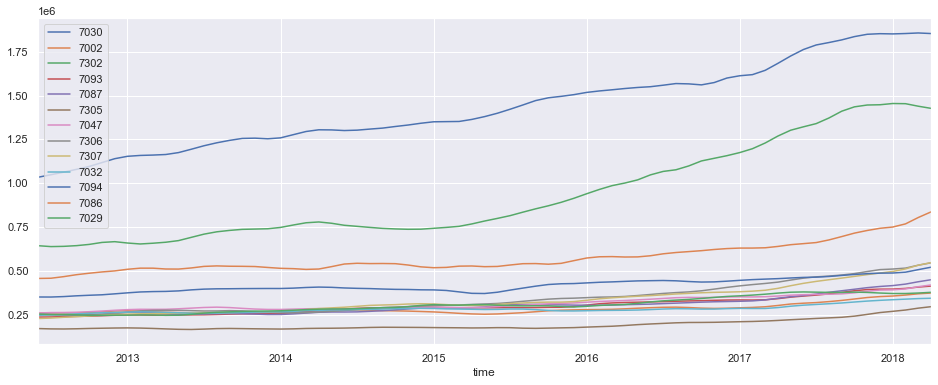

In [16]:
for i in range(len(df_NJ_HudsonZC)):
    df_NJ_HudsonZC[i][start:]['value'].plot(label=  list_zip[i], figsize = (16,6))
    plt.legend()

In [17]:
index_outliers = []
Outliers_zip = [7030, 7302, 7086]
for i in range(len(df_NJ_HudsonZC)):
    for j in range(len(Outliers_zip)):
        if df_NJ_HudsonZC[i]['RegionName'][0] == Outliers_zip[j]:
            index_outliers.append(i)

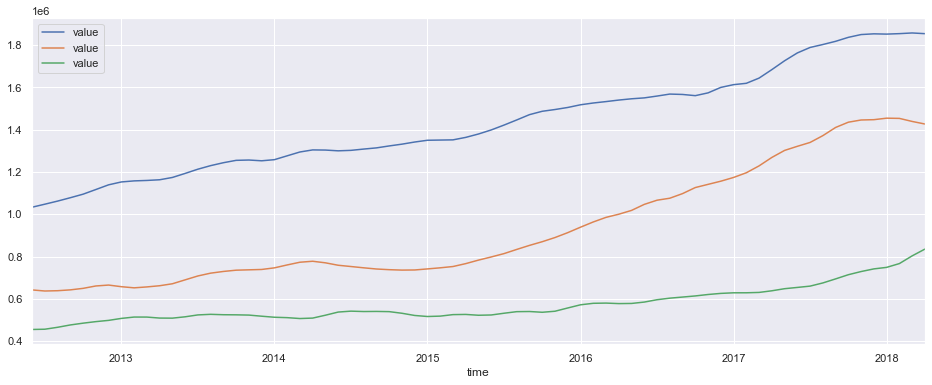

In [18]:
for i in range(len(index_outliers)):
    df_NJ_HudsonZC[index_outliers[i]][start:]['value'].plot(figsize = (16,6))
    plt.legend()

In [ ]:
plt.subplots_adjust(top=2, wspace=.5, hspace=0.2)
plt.subplot(5,1,1)
df_ZC_best5[0]['mreturns'].plot(figsize = (16,15))
plt.title(f'Month to Month ROI for {df_ZC_best5[0].City[0]}', fontweight ="bold", fontsize = 14)
plt.ylabel('Month to Month ROI %')

plt.subplot(5,1,2)
df_ZC_best5[1]['mreturns'].plot(figsize = (16,15))
plt.title(f'Month to Month ROI for {df_ZC_best5[1].City[0]}', fontweight ="bold", fontsize = 14)
plt.ylabel('Month to Month ROI %')

plt.subplot(5,1,3)
df_ZC_best5[2]['mreturns'].plot(figsize = (16,15))
plt.title(f'Month to Month ROI for {df_ZC_best5[2].City[0]}', fontweight ="bold", fontsize = 14)
plt.ylabel('Month to Month ROI %')

plt.subplot(5,1,4)
df_ZC_best5[3]['mreturns'].plot(figsize = (16,15))
plt.title(f'Month to Month ROI for {df_ZC_best5[3].City[0]}', fontweight ="bold", fontsize = 14)
plt.ylabel('Month to Month ROI %')

plt.subplot(5,1,5)
df_ZC_best5[4]['mreturns'].plot(figsize = (16,15))
plt.title(f'Month to Month ROI for {df_ZC_best5[4].City[0]}', fontweight ="bold", fontsize = 14)
plt.ylabel('Month to Month ROI %')

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<function matplotlib.pyplot.show(*args, **kw)>

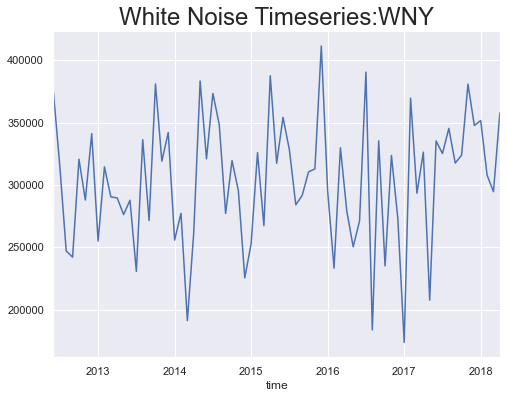

In [19]:
df_wny = df_NJ_HudsonZC[3][start:]
wn = np.random.normal(loc =df_NJ_HudsonZC[3][start:]['value'].mean(), scale = df_NJ_HudsonZC[3][start:]['value'].std(), size= len(df_NJ_HudsonZC[3][start:]['value']))
df_wny['wn'] = wn
## plot the randomly generated white noise 
df_wny.wn.plot()
plt.title('White Noise Timeseries:WNY', size=24)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

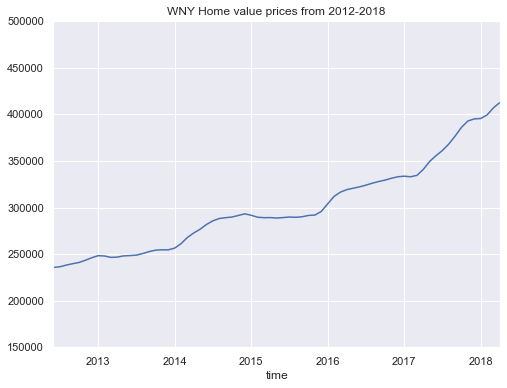

In [20]:
df_wny.value.plot()
plt.title('WNY Home value prices from 2012-2018')
plt.ylim(150000, 500000)
plt.show

In order to make good forcast we need to reconize the patterns that this time series follows

Market Efficiency
 - Measures the level of difficulty in forecasting correct future values 
     - If a time series resembles a random walk the prices can't be predicted with great accuracy 
     - if the time series can be predicted with great accuracy than there are **Arbitrage oppurtunities**

Arbitrage Example: 
- Buy and sell commodities and make a safe profit, while the price adjusts

In [21]:
def stationarity_check(df,df_name):
    # Create rolling mean and std to test for trends
    roll_mean = df.rolling(window=8, center=False).mean()
    roll_std = df.rolling(window=8, center=False).std()
    
    # The Dickey-Fuller Test
    from statsmodels.tsa.stattools import adfuller
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(df)
    # Plot rolling statistics
    fig = plt.figure(figsize=(12,7))
    plt.plot(df, color = 'blue', label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation ' + df_name)
    plt.show(block=False)
    
    #Print Dickey_fuller test results
    print('Results of the Dickey-Fuller Test: \n')

    #Extract and display test results in a user friendly manner
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observation'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    return None

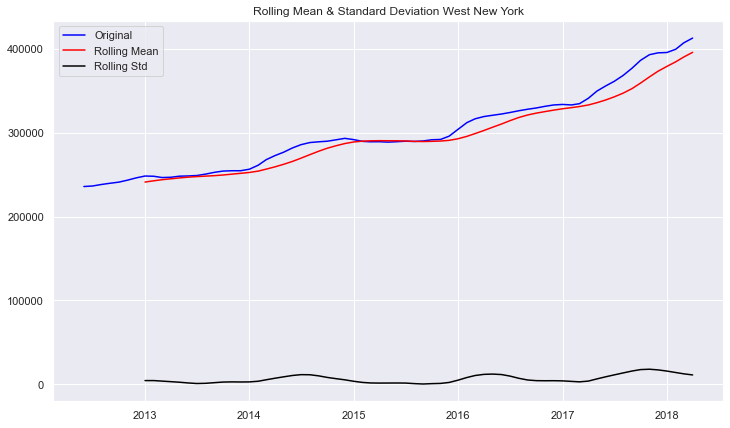

Results of the Dickey-Fuller Test: 

Test Statistic            2.519675
p-value                   0.999056
#lags Used               11.000000
Number of Observation    59.000000
Critical Value (1%)      -3.546395
Critical Value (5%)      -2.911939
Critical Value (10%)     -2.593652
dtype: float64


In [22]:
stationarity_check(df_NJ_HudsonZC[3][start:]['value'], df_NJ_HudsonZC[3].City[0])

# Pre-Processing Time Series: Stationarity
I will begin by trying to transform the time series into a stationary state by applying differencing.
- Note: In this analysis I first tried to evaluate the time series after differencing once and found that all the values were still not stationary. In this case another option you can try to find how many differencing you need to perform is by 

In [23]:
df_diff2 = []
for i in range(len(df_NJ_HudsonZC)):
    #Perform one differencing in all 
    df_diff = df_NJ_HudsonZC[i][start:]['value'].diff().diff()
    df_diff.isna().sum()
    df_diff.dropna(inplace=True)

    df_diff2.append(df_diff)

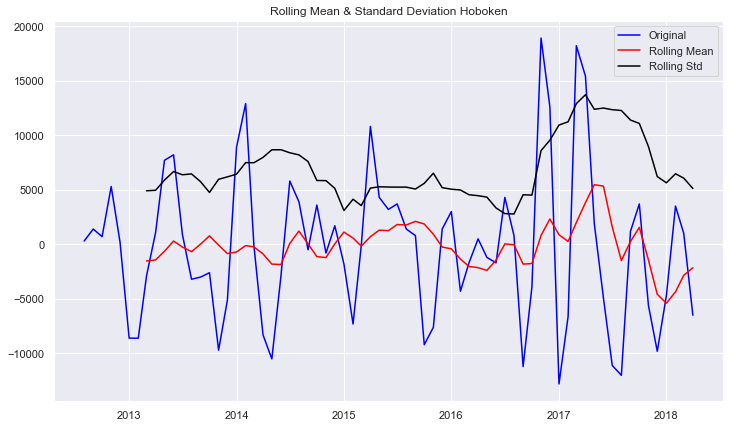

Results of the Dickey-Fuller Test: 

Test Statistic           -3.717489
p-value                   0.003874
#lags Used               11.000000
Number of Observation    57.000000
Critical Value (1%)      -3.550670
Critical Value (5%)      -2.913766
Critical Value (10%)     -2.594624
dtype: float64


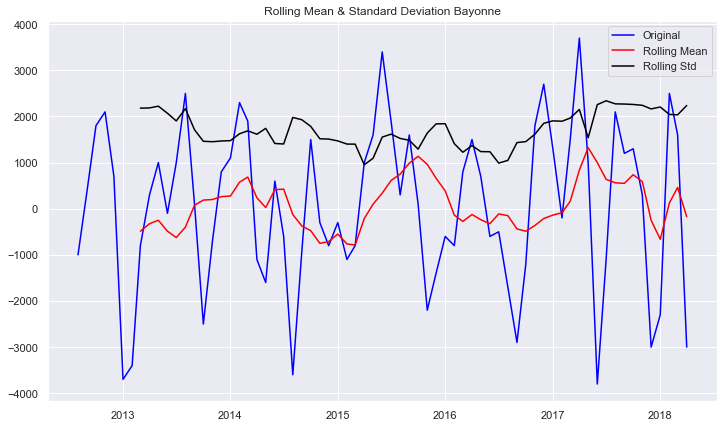

Results of the Dickey-Fuller Test: 

Test Statistic           -4.295475
p-value                   0.000452
#lags Used               11.000000
Number of Observation    57.000000
Critical Value (1%)      -3.550670
Critical Value (5%)      -2.913766
Critical Value (10%)     -2.594624
dtype: float64


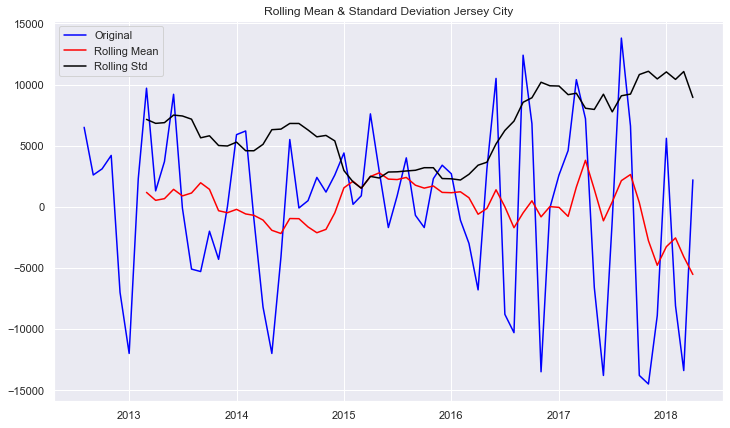

Results of the Dickey-Fuller Test: 

Test Statistic           -4.655017
p-value                   0.000102
#lags Used                2.000000
Number of Observation    66.000000
Critical Value (1%)      -3.533560
Critical Value (5%)      -2.906444
Critical Value (10%)     -2.590724
dtype: float64


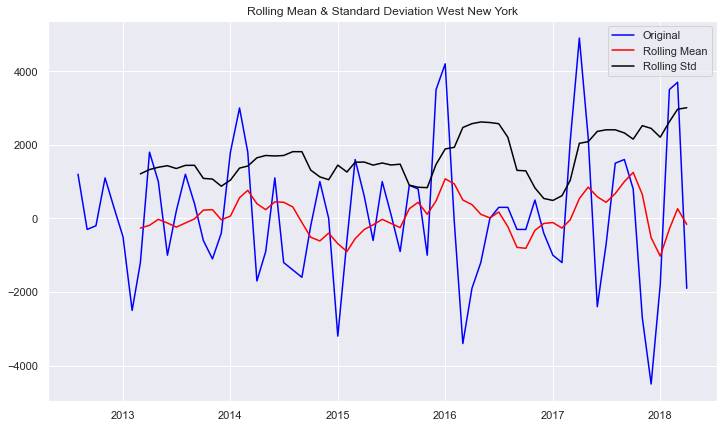

Results of the Dickey-Fuller Test: 

Test Statistic           -4.260622
p-value                   0.000519
#lags Used                6.000000
Number of Observation    62.000000
Critical Value (1%)      -3.540523
Critical Value (5%)      -2.909427
Critical Value (10%)     -2.592314
dtype: float64


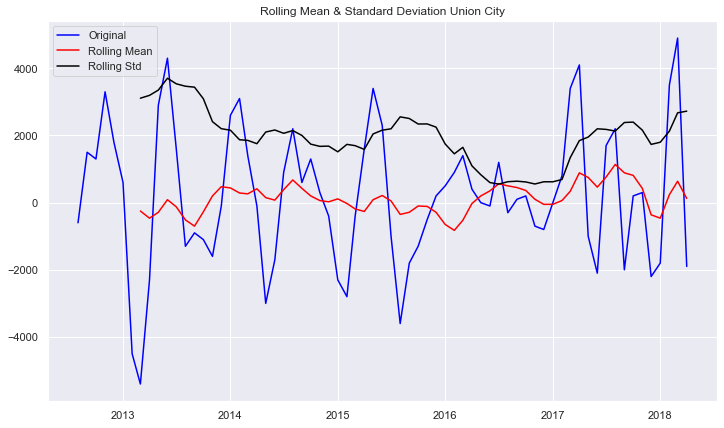

Results of the Dickey-Fuller Test: 

Test Statistic           -4.630772
p-value                   0.000113
#lags Used                5.000000
Number of Observation    63.000000
Critical Value (1%)      -3.538695
Critical Value (5%)      -2.908645
Critical Value (10%)     -2.591897
dtype: float64


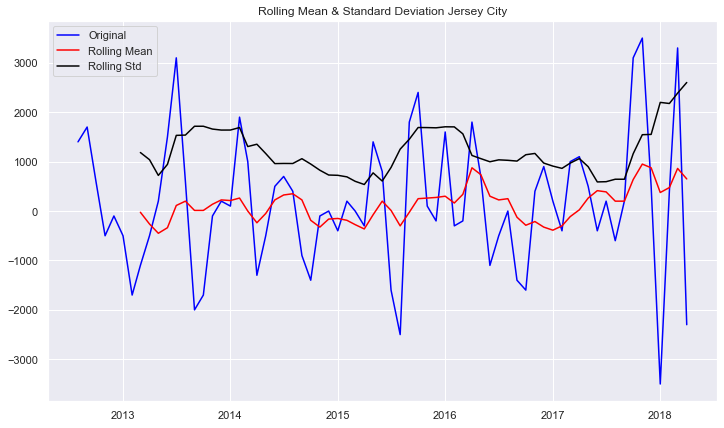

Results of the Dickey-Fuller Test: 

Test Statistic           -5.455397
p-value                   0.000003
#lags Used                3.000000
Number of Observation    65.000000
Critical Value (1%)      -3.535217
Critical Value (5%)      -2.907154
Critical Value (10%)     -2.591103
dtype: float64


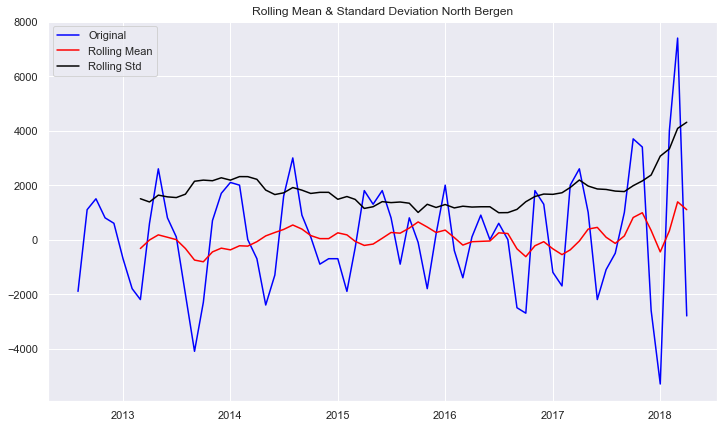

Results of the Dickey-Fuller Test: 

Test Statistic          -6.641766e+00
p-value                  5.387638e-09
#lags Used               3.000000e+00
Number of Observation    6.500000e+01
Critical Value (1%)     -3.535217e+00
Critical Value (5%)     -2.907154e+00
Critical Value (10%)    -2.591103e+00
dtype: float64


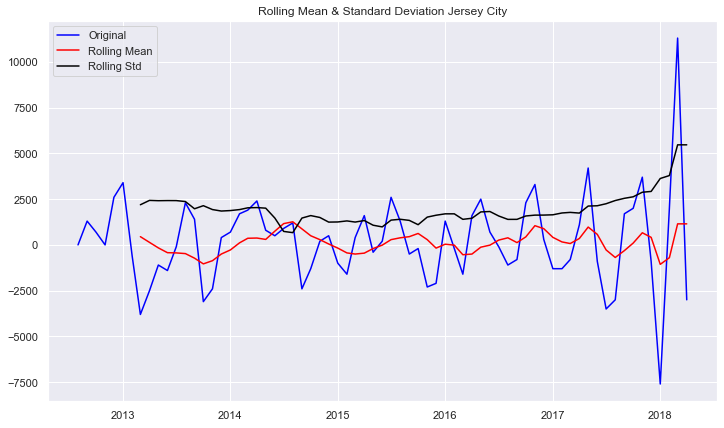

Results of the Dickey-Fuller Test: 

Test Statistic           -4.685287
p-value                   0.000090
#lags Used                6.000000
Number of Observation    62.000000
Critical Value (1%)      -3.540523
Critical Value (5%)      -2.909427
Critical Value (10%)     -2.592314
dtype: float64


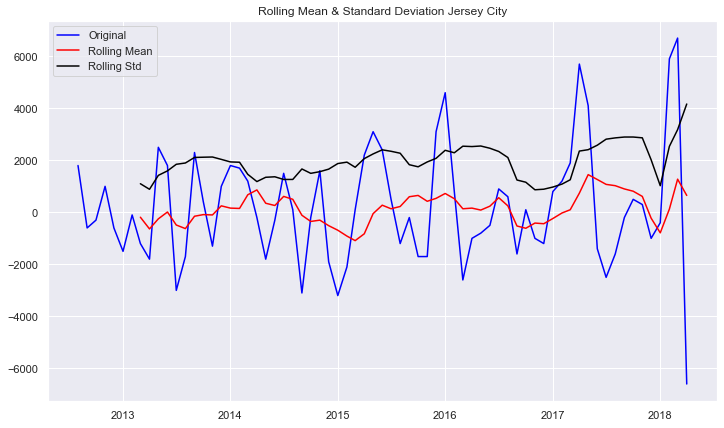

Results of the Dickey-Fuller Test: 

Test Statistic           -3.418407
p-value                   0.010347
#lags Used               10.000000
Number of Observation    58.000000
Critical Value (1%)      -3.548494
Critical Value (5%)      -2.912837
Critical Value (10%)     -2.594129
dtype: float64


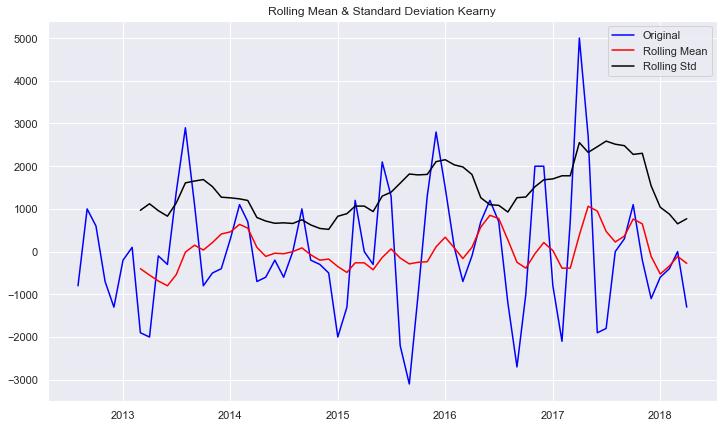

Results of the Dickey-Fuller Test: 

Test Statistic           -3.678684
p-value                   0.004423
#lags Used                5.000000
Number of Observation    63.000000
Critical Value (1%)      -3.538695
Critical Value (5%)      -2.908645
Critical Value (10%)     -2.591897
dtype: float64


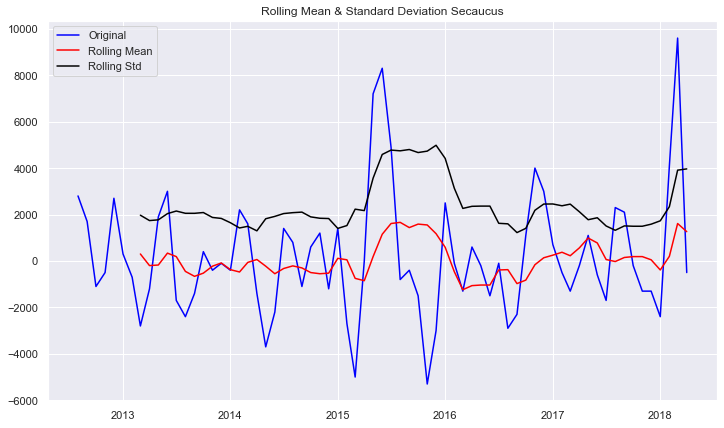

Results of the Dickey-Fuller Test: 

Test Statistic           -5.640826
p-value                   0.000001
#lags Used                3.000000
Number of Observation    65.000000
Critical Value (1%)      -3.535217
Critical Value (5%)      -2.907154
Critical Value (10%)     -2.591103
dtype: float64


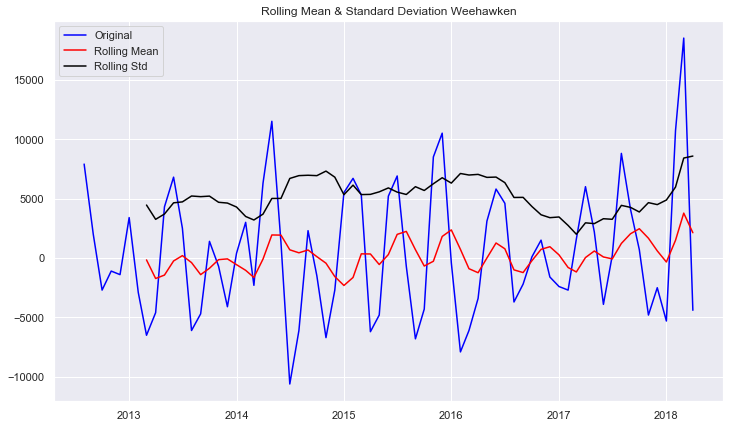

Results of the Dickey-Fuller Test: 

Test Statistic           -4.794042
p-value                   0.000056
#lags Used                6.000000
Number of Observation    62.000000
Critical Value (1%)      -3.540523
Critical Value (5%)      -2.909427
Critical Value (10%)     -2.592314
dtype: float64


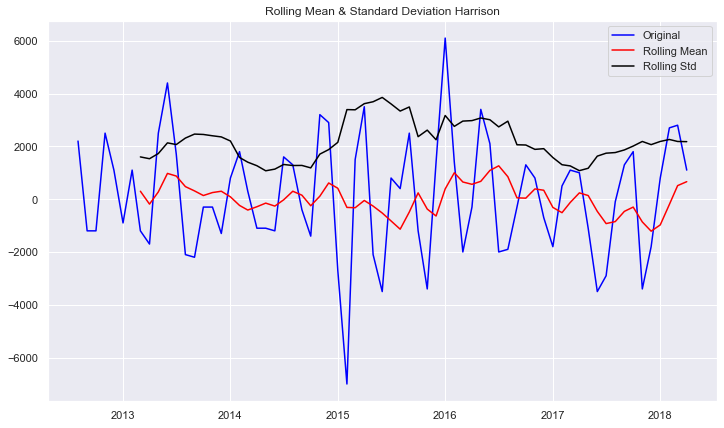

Results of the Dickey-Fuller Test: 

Test Statistic          -1.133951e+01
p-value                  1.063158e-20
#lags Used               1.000000e+00
Number of Observation    6.700000e+01
Critical Value (1%)     -3.531955e+00
Critical Value (5%)     -2.905755e+00
Critical Value (10%)    -2.590357e+00
dtype: float64


In [24]:
for i in range(len(df_diff2)):    
    stationarity_check(df_diff2[i], df_NJ_HudsonZC[i].City[0])

# ACF & PACF
- ACF : q parameter (MA)
- PACF : p parameter (AR)

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained un

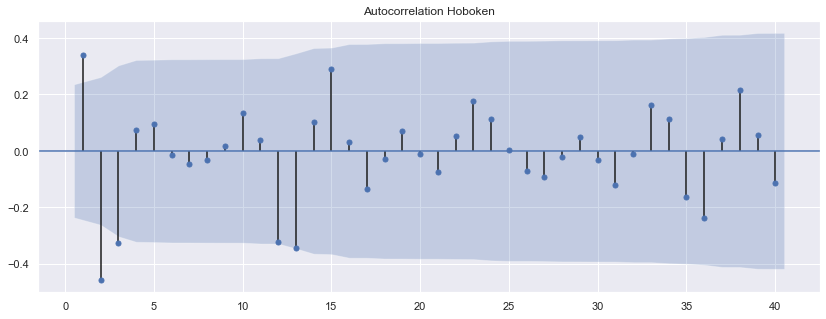

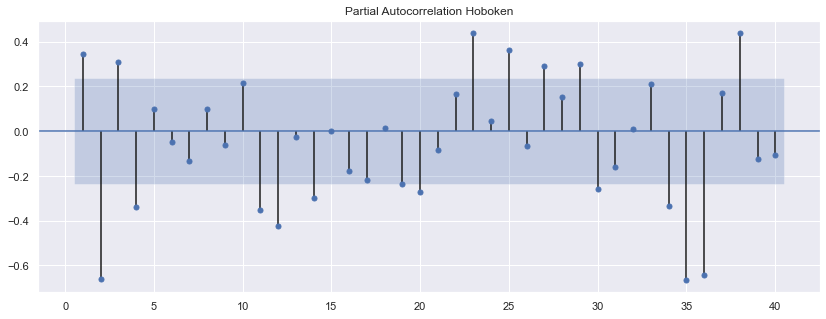

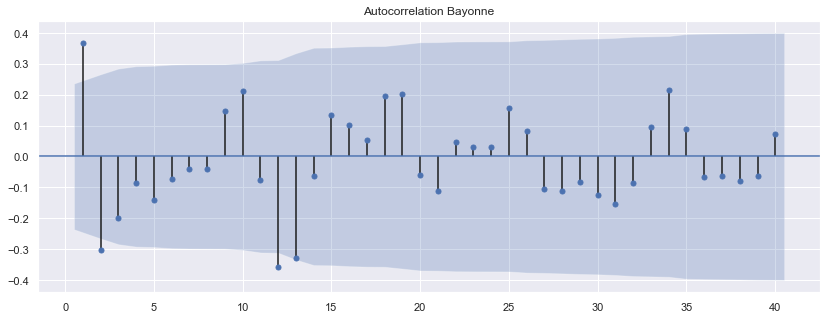

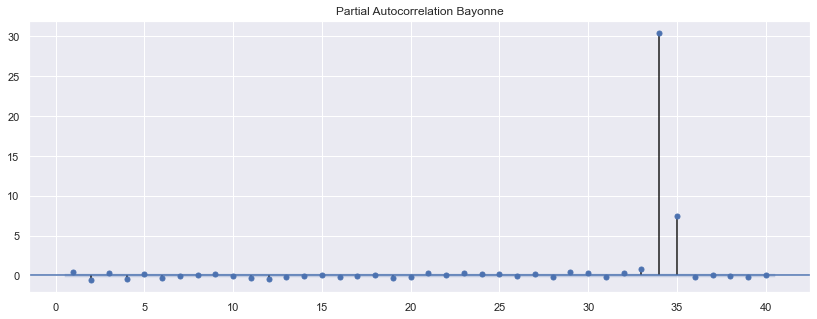

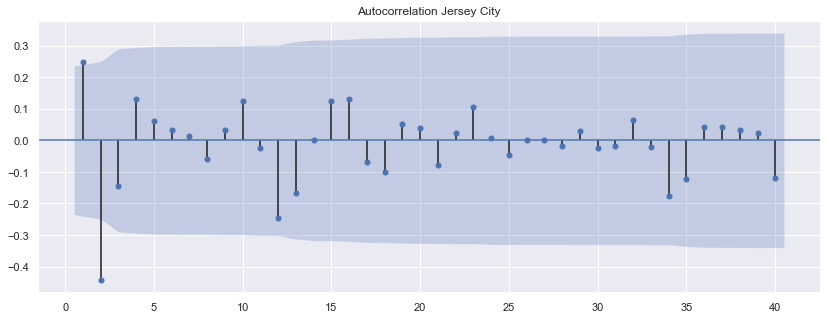

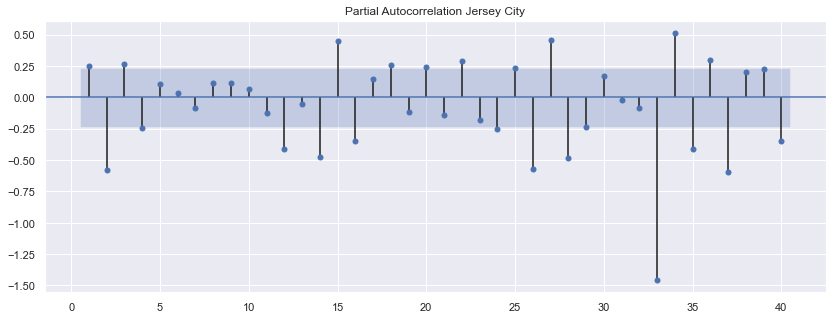

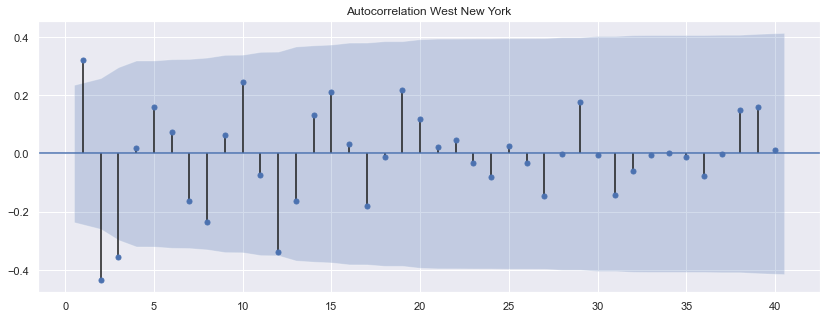

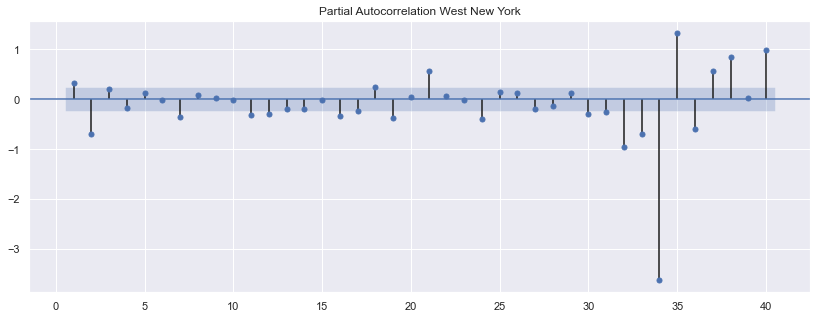

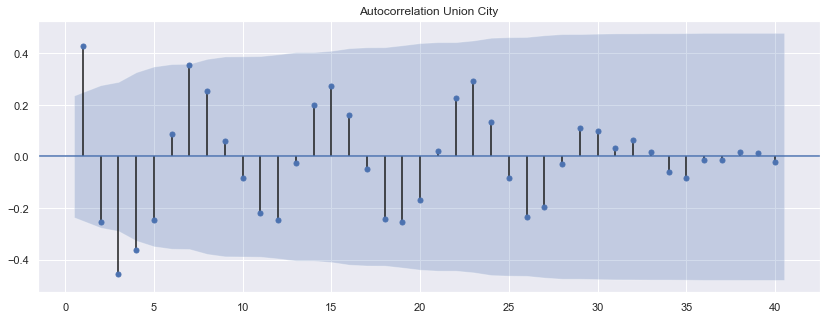

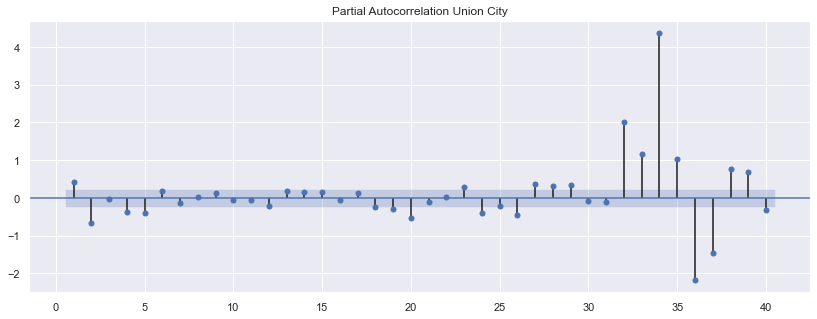

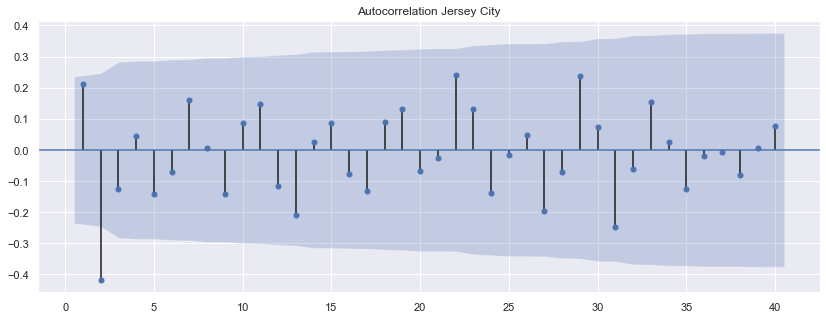

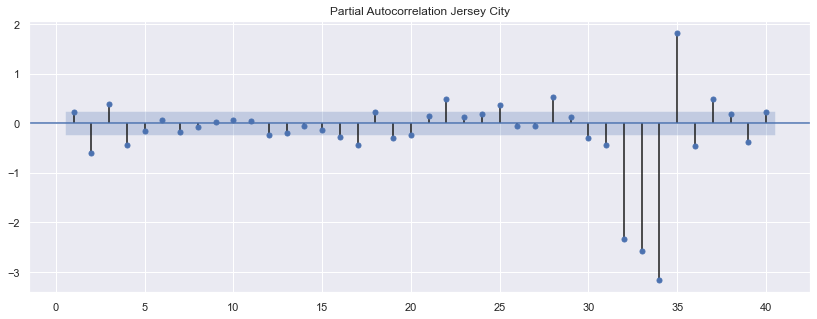

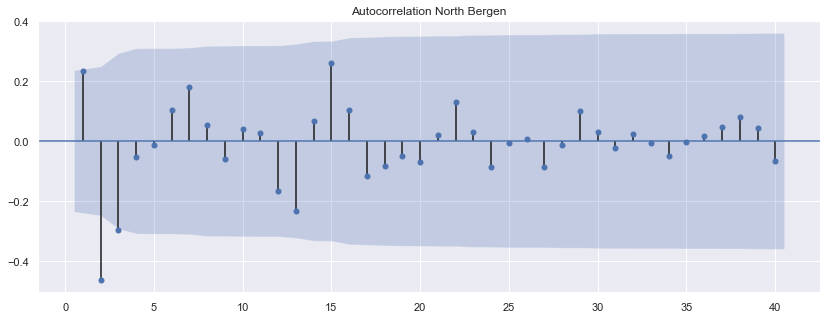

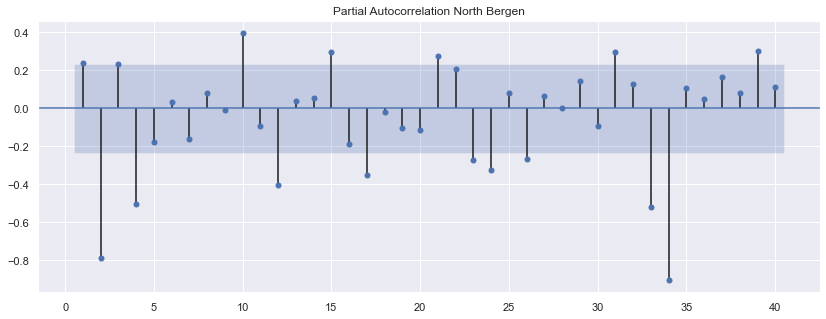

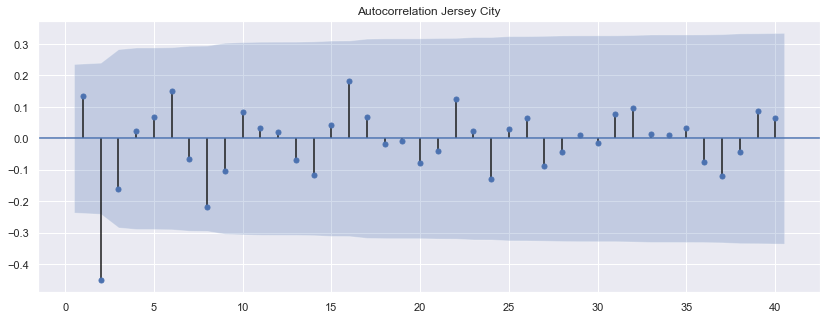

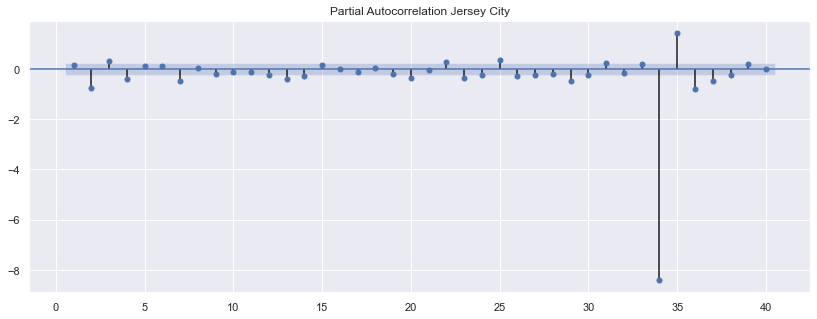

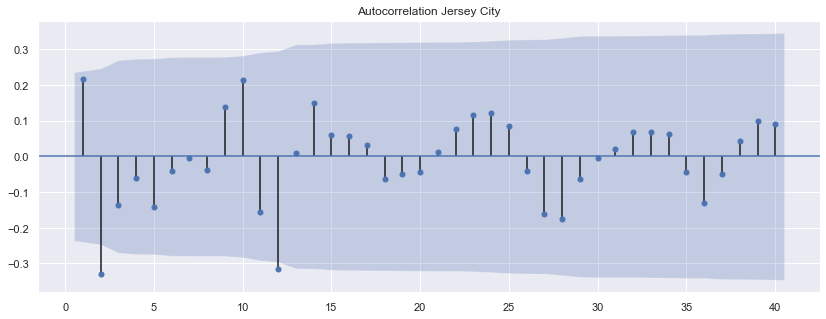

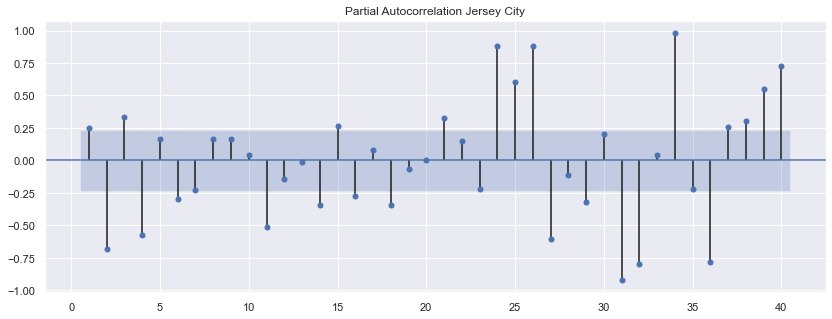

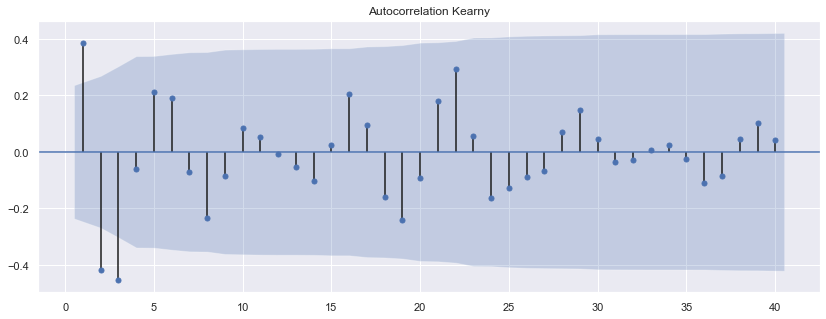

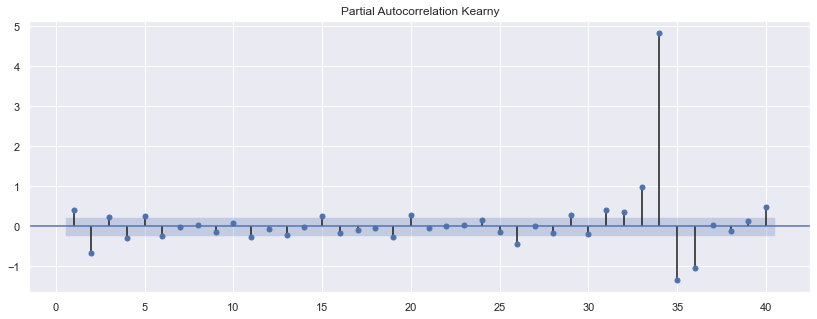

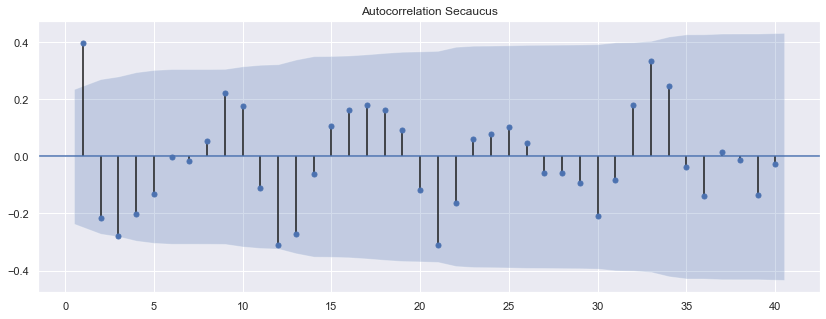

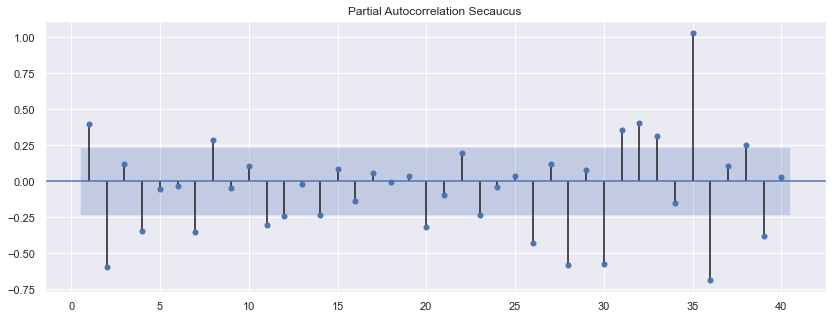

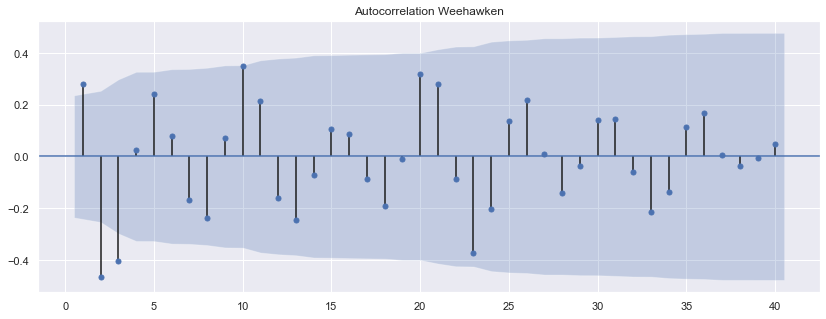

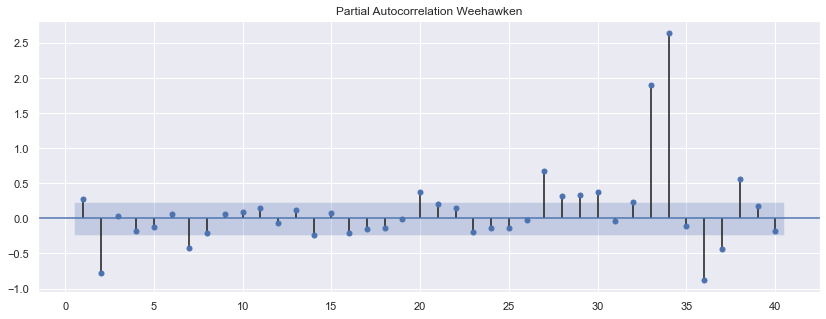

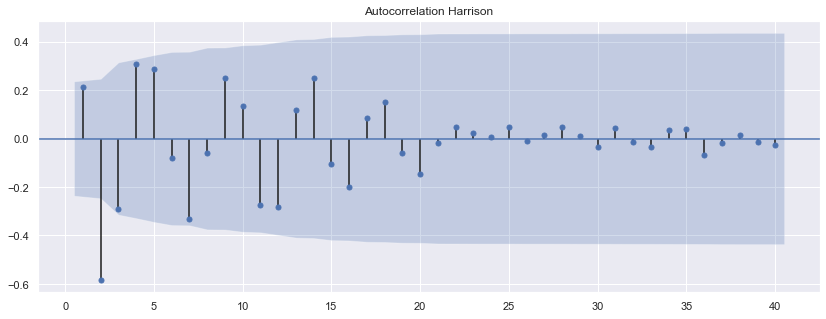

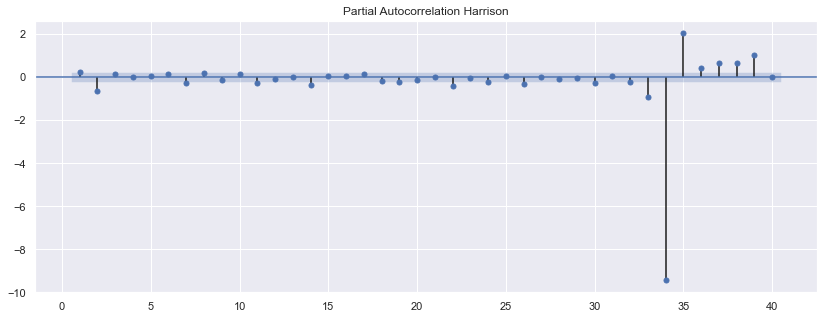

In [25]:
rcParams['figure.figsize'] = 14,5
for i in range(len(df_diff2)):
    plot_acf(df_diff2[i], title='Autocorrelation '+ df_NJ_HudsonZC[i].City[0], lags=40, zero=False,);
    plot_pacf(df_diff2[i], title='Partial Autocorrelation '+ df_NJ_HudsonZC[i].City[0], lags=40, zero=False, method=('ols'));

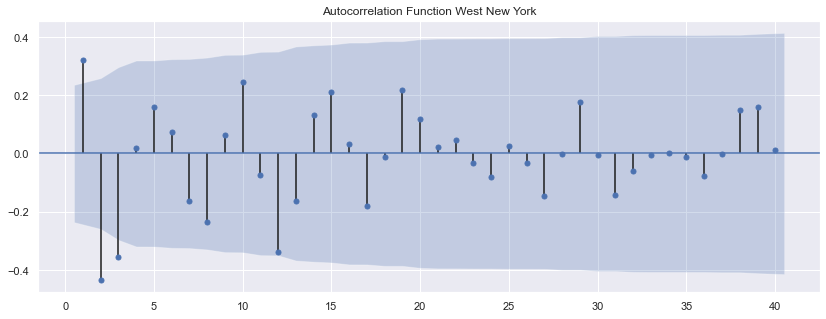

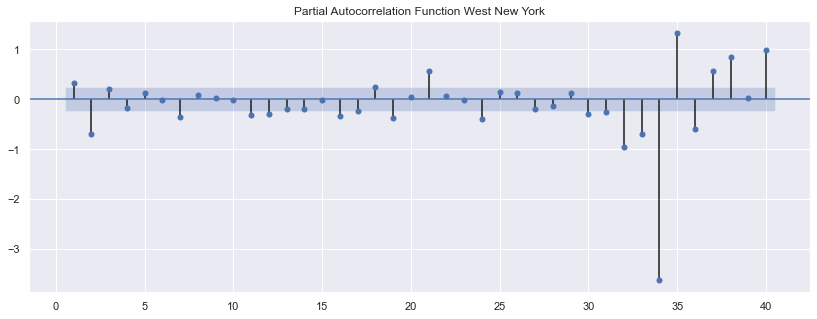

In [26]:
plot_acf(df_diff2[3], title='Autocorrelation Function '+ df_NJ_HudsonZC[3].City[0], lags=40, zero=False);
plot_pacf(df_diff2[3], title='Partial Autocorrelation Function '+ df_NJ_HudsonZC[3].City[0], lags=40, zero=False, method=('ols'));

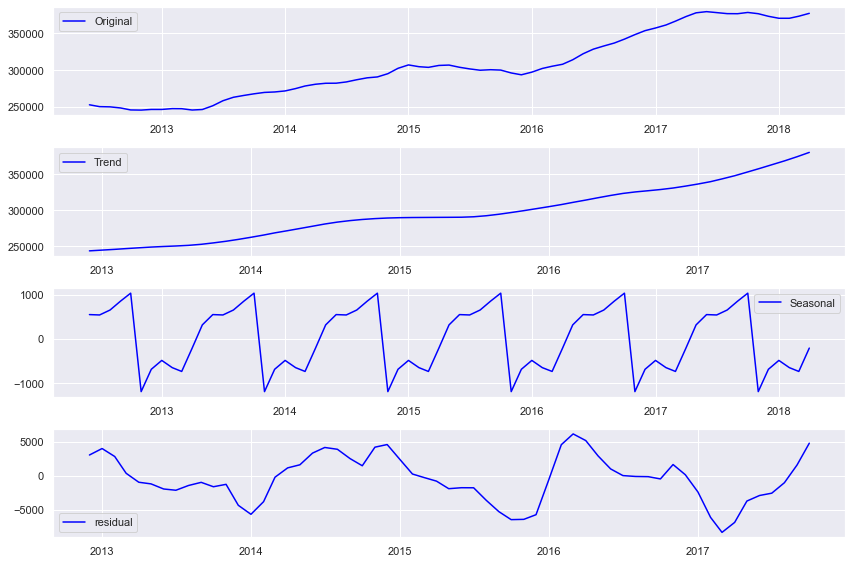

In [27]:
decomposition = seasonal_decompose(df_NJ_HudsonZC[3][start:]['value'], model = 'additive')

# Gather the trend, seasonality, and residuals
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df_NJ_HudsonZC[i][start:]['value'], label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='residual', color='blue')
plt.legend(loc='best')
plt.tight_layout()

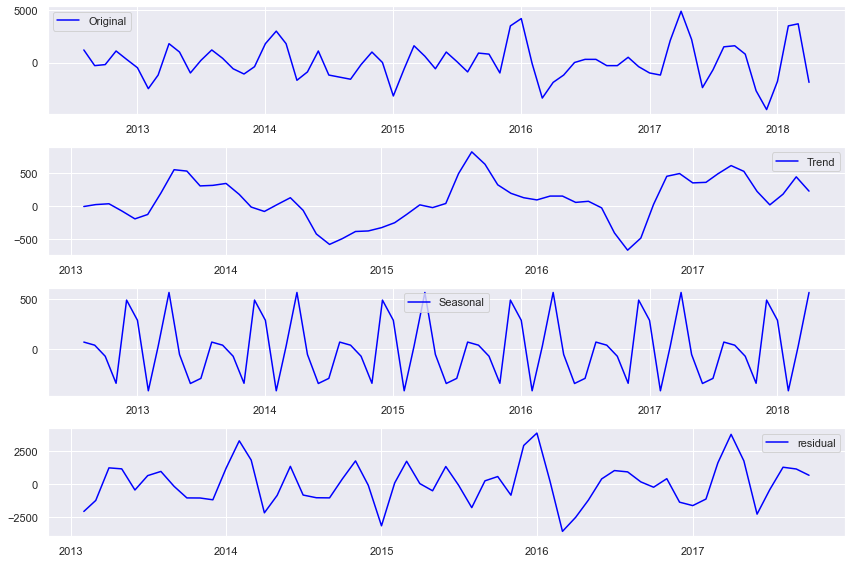

In [28]:
decomposition = seasonal_decompose(df_diff2[3])

# Gather the trend, seasonality, and residuals
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df_diff2[3], label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='residual', color='blue')
plt.legend(loc='best')
plt.tight_layout()

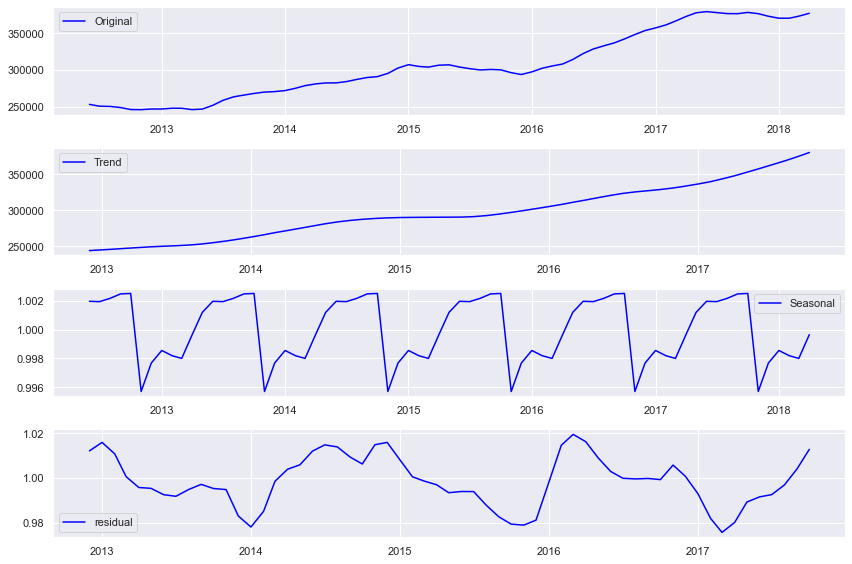

In [75]:
decomposition = seasonal_decompose(df_NJ_HudsonZC[3][start:]['value'], model = 'multiplicative')

# Gather the trend, seasonality, and residuals
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df_NJ_HudsonZC[i][start:]['value'], label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='residual', color='blue')
plt.legend(loc='best')
plt.tight_layout()

In [29]:
def train_test(df):
    pred_start = datetime(2017,1,1)
    pred_end = datetime(2018,1,1)

    # Setting the train data to extend to 1-1-2017
    train = df[:pred_start]
    # Setting the test data to extend to 1-1-2018
    test = df[pred_start + timedelta(days=1):pred_end]
    return train, test

In [30]:
def model_fit_ARIMA(df,pdq=(0,2,0)):
    train, test = train_test(df)
    model_arima = ARIMA(train,order=pdq)
    results = model_arima.fit()
    results.summary
    residuals = results.resid
    print(results.summary())
    return train, test, results

In [31]:
pdq = (2,2,0)
train, test, results = model_fit_ARIMA(df_NJ_HudsonZC[3][start:]['value'], pdq=pdq)

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   54
Model:                 ARIMA(2, 2, 0)   Log Likelihood                -458.322
Method:                       css-mle   S.D. of innovations           1166.446
Date:                Sun, 11 Apr 2021   AIC                            924.643
Time:                        00:11:01   BIC                            932.599
Sample:                    08-01-2012   HQIC                           927.712
                         - 01-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              6.2765    152.268      0.041      0.967    -292.163     304.716
ar.L1.D2.value     0.4678      0.116      4.036      0.000       0.241       0.695
ar.L2.D2.value    -0.5210      0.113

ARIMA model RMSE on train data: 1201.37124
ARIMA model RMSE on test data: 33131.03595


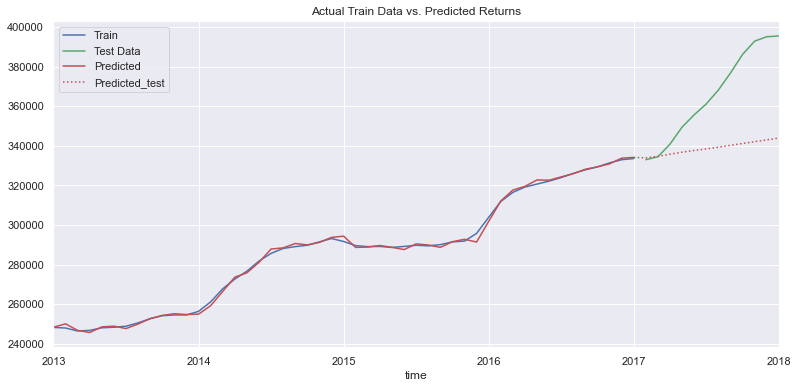

In [32]:
pred_start = datetime(2013,1,1)
pred_end = datetime(2017,1,1)
test_start = datetime(2017,1,1)
test_end = datetime(2018,1,1)

train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred[test_start + timedelta(days=1):test_end]))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

plt.figure(figsize=(13,6))
train[pred_start:pred_end].plot(label='Train',color='b')
test[test_start:test_end].plot(label='Test Data',color='g')
train_pred.plot(label='Predicted',color='r')
test_pred.plot(label='Predicted_test', color='r',ls=':')
plt.legend(loc='best')
plt.title('Actual Train Data vs. Predicted Returns')
plt.show()

In [36]:
import warnings
warnings.filterwarnings('ignore')
import itertools
d=range(0,3)
p=range(0,35)
q=range(0,1)
pdq = list(itertools.product(p,d,q))

params=[]
aics=[]
LL=[]

for param in pdq:
    try:
        model_arima = ARIMA(train, order=param)
        model_arima_fit = model_arima.fit()
        params.append(param)
        aics.append(model_arima_fit.aic)
        LL.append(model_arima_fit.llf)
        
    except:
        continue
data_param = {'param':params,'AIC':aics, 'LLf':LL}
df_param = pd.DataFrame(data_param)
df_param.sort_values(by='AIC').head()

,param,AIC,LLf
38,"(12, 2, 0)",919.820261,-445.910130
35,"(11, 2, 0)",920.364437,-447.182218
41,"(13, 2, 0)",921.811482,-445.905741
14,"(4, 2, 0)",923.557447,-455.778723
48,"(16, 2, 0)",923.747065,-443.873533


# For Educational Purpose: AR models
Here I will be comparing the Log Likelyhood Ratio to determine if the difference is signicant. 
In conclusion I have learned that as you continue to add more lags into the model you will eventually find lags that will add more insight and predict powers to the model. However, as you continue to add more lags the less chances the model will have to use its perdictive powers to new data. 
Here you will see that as we move past lag=2 the LLT is not significant until we reach to lags past 11 we start seeing an increase to predictive power. 

Questions: When exactly should you stop adding higher lag orders

In [ ]:
from scipy.stats import chi2
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf 
    LR = (2*(L2-L1))
    p = chi2.sf(LR,DF).round(3)
    return p

In [67]:
train, test = train_test(df_NJ_HudsonZC[3][start:]['value'])
model_arima_2 = ARIMA(train,order=(2,2,0))
results_2 = model_arima_2.fit()
results_2.summary()
residuals_2 = results_2.resid
print(results_2.summary())
    

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   54
Model:                 ARIMA(2, 2, 0)   Log Likelihood                -458.322
Method:                       css-mle   S.D. of innovations           1166.446
Date:                Sun, 11 Apr 2021   AIC                            924.643
Time:                        16:08:06   BIC                            932.599
Sample:                    08-01-2012   HQIC                           927.712
                         - 01-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              6.2765    152.268      0.041      0.967    -292.163     304.716
ar.L1.D2.value     0.4678      0.116      4.036      0.000       0.241       0.695
ar.L2.D2.value    -0.5210      0.113

In [68]:
train, test = train_test(df_NJ_HudsonZC[3][start:]['value'])
model_arima_3 = ARIMA(train,order=(3,2,0))
results_3 = model_arima_3.fit()
residuals_3 = results_3.resid
print(results_3.summary())
print('\nLLR test p-value =' + str(LLR_test(model_arima_2,model_arima_3)))



                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   54
Model:                 ARIMA(3, 2, 0)   Log Likelihood                -457.206
Method:                       css-mle   S.D. of innovations           1141.219
Date:                Sun, 11 Apr 2021   AIC                            924.412
Time:                        16:08:31   BIC                            934.357
Sample:                    08-01-2012   HQIC                           928.247
                         - 01-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              8.3525    184.921      0.045      0.964    -354.086     370.791
ar.L1.D2.value     0.5775      0.135      4.290      0.000       0.314       0.841
ar.L2.D2.value    -0.6173      0.127

In [69]:
train, test = train_test(df_NJ_HudsonZC[3][start:]['value'])
model_arima_4 = ARIMA(train,order=(4,2,0))
results_4 = model_arima_4.fit()
residuals_4 = results_4.resid
print(results_4.summary())
print('\nLLR test p-value =' + str(LLR_test(model_arima_3,model_arima_4)))

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   54
Model:                 ARIMA(4, 2, 0)   Log Likelihood                -455.779
Method:                       css-mle   S.D. of innovations           1109.199
Date:                Sun, 11 Apr 2021   AIC                            923.557
Time:                        16:08:48   BIC                            935.491
Sample:                    08-01-2012   HQIC                           928.160
                         - 01-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.7189    148.340      0.039      0.969    -285.022     296.460
ar.L1.D2.value     0.6215      0.133      4.656      0.000       0.360       0.883
ar.L2.D2.value    -0.7615      0.150

In [75]:
train, test = train_test(df_NJ_HudsonZC[3][start:]['value'])
model_arima_5 = ARIMA(train,order=(5,2,0))
results_5 = model_arima_5.fit()
residuals_5 = results_5.resid
print(results_5.summary())
print('\nLLR test p-value =' + str(LLR_test(model_arima_4,model_arima_5)))

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   54
Model:                 ARIMA(5, 2, 0)   Log Likelihood                -455.772
Method:                       css-mle   S.D. of innovations           1109.052
Date:                Sun, 11 Apr 2021   AIC                            925.544
Time:                        16:33:22   BIC                            939.467
Sample:                    08-01-2012   HQIC                           930.913
                         - 01-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.5477    146.152      0.038      0.970    -280.905     292.000
ar.L1.D2.value     0.6177      0.137      4.498      0.000       0.349       0.887
ar.L2.D2.value    -0.7562      0.157

In [76]:
train, test = train_test(df_NJ_HudsonZC[3][start:]['value'])
model_arima_6 = ARIMA(train,order=(6,2,0))
results_6 = model_arima_6.fit()
residuals_6 = results_6.resid
print(results_6.summary())
print('\nLLR test p-value =' + str(LLR_test(model_arima_5,model_arima_6)))

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   54
Model:                 ARIMA(6, 2, 0)   Log Likelihood                -455.753
Method:                       css-mle   S.D. of innovations           1108.625
Date:                Sun, 11 Apr 2021   AIC                            927.507
Time:                        16:33:27   BIC                            943.419
Sample:                    08-01-2012   HQIC                           933.643
                         - 01-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.0322    142.675      0.035      0.972    -274.605     284.669
ar.L1.D2.value     0.6172      0.137      4.495      0.000       0.348       0.886
ar.L2.D2.value    -0.7621      0.160

In [78]:
train, test = train_test(df_NJ_HudsonZC[3][start:]['value'])
model_arima_7 = ARIMA(train,order=(7,2,0))
results_7 = model_arima_7.fit()
residuals_7 = results_7.resid
print(results_7.summary())
print('\nLLR test p-value =' + str(LLR_test(model_arima_6,model_arima_7)))

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   54
Model:                 ARIMA(7, 2, 0)   Log Likelihood                -453.512
Method:                       css-mle   S.D. of innovations           1057.783
Date:                Sun, 11 Apr 2021   AIC                            925.024
Time:                        16:35:40   BIC                            942.925
Sample:                    08-01-2012   HQIC                           931.928
                         - 01-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             11.8395    109.150      0.108      0.914    -202.090     225.769
ar.L1.D2.value     0.6186      0.130      4.744      0.000       0.363       0.874
ar.L2.D2.value    -0.7644      0.151

In [79]:
train, test = train_test(df_NJ_HudsonZC[3][start:]['value'])
model_arima_8 = ARIMA(train,order=(8,2,0))
results_8 = model_arima_8.fit()
residuals_8 = results_8.resid
print(results_8.summary())
print('\nLLR test p-value =' + str(LLR_test(model_arima_7,model_arima_8)))

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   54
Model:                 ARIMA(8, 2, 0)   Log Likelihood                -452.091
Method:                       css-mle   S.D. of innovations           1025.924
Date:                Sun, 11 Apr 2021   AIC                            924.182
Time:                        17:01:32   BIC                            944.072
Sample:                    08-01-2012   HQIC                           931.853
                         - 01-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              8.7338    134.107      0.065      0.948    -254.110     271.578
ar.L1.D2.value     0.6919      0.133      5.195      0.000       0.431       0.953
ar.L2.D2.value    -0.8101      0.148

In [80]:
train, test = train_test(df_NJ_HudsonZC[3][start:]['value'])
model_arima_9 = ARIMA(train,order=(9,2,0))
results_9 = model_arima_9.fit()
residuals_9 = results_9.resid
print(results_9.summary())
print('\nLLR test p-value =' + str(LLR_test(model_arima_8,model_arima_9)))

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   54
Model:                 ARIMA(9, 2, 0)   Log Likelihood                -451.965
Method:                       css-mle   S.D. of innovations           1023.309
Date:                Sun, 11 Apr 2021   AIC                            925.930
Time:                        17:06:57   BIC                            947.809
Sample:                    08-01-2012   HQIC                           934.368
                         - 01-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              6.7695    142.113      0.048      0.962    -271.767     285.306
ar.L1.D2.value     0.6752      0.137      4.936      0.000       0.407       0.943
ar.L2.D2.value    -0.7762      0.162

In [81]:
train, test = train_test(df_NJ_HudsonZC[3][start:]['value'])
model_arima_10 = ARIMA(train,order=(10,2,0))
results_10 = model_arima_10.fit()
residuals_10 = results_10.resid
print(results_10.summary())
print('\nLLR test p-value =' + str(LLR_test(model_arima_9,model_arima_10)))

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   54
Model:                ARIMA(10, 2, 0)   Log Likelihood                -451.751
Method:                       css-mle   S.D. of innovations           1018.366
Date:                Sun, 11 Apr 2021   AIC                            927.502
Time:                        17:17:30   BIC                            951.370
Sample:                    08-01-2012   HQIC                           936.707
                         - 01-01-2017                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              12.1741    131.942      0.092      0.926    -246.427     270.776
ar.L1.D2.value      0.6835      0.137      5.006      0.000       0.416       0.951
ar.L2.D2.value     -0.7606      

In [82]:
train, test = train_test(df_NJ_HudsonZC[3][start:]['value'])
model_arima_11 = ARIMA(train,order=(11,2,0))
results_11 = model_arima_11.fit()
residuals_11 = results_11.resid
print(results_11.summary())
print('\nLLR test p-value =' + str(LLR_test(model_arima_10,model_arima_11)))

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   54
Model:                ARIMA(11, 2, 0)   Log Likelihood                -447.182
Method:                       css-mle   S.D. of innovations            917.234
Date:                Sun, 11 Apr 2021   AIC                            920.364
Time:                        17:19:05   BIC                            946.221
Sample:                    08-01-2012   HQIC                           930.336
                         - 01-01-2017                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              46.8418     83.921      0.558      0.577    -117.641     211.325
ar.L1.D2.value      0.6370      0.122      5.242      0.000       0.399       0.875
ar.L2.D2.value     -0.7150      

In [73]:
train, test = train_test(df_NJ_HudsonZC[3][start:]['value'])
model_arima_12 = ARIMA(train,order=(12,2,0))
results_12 = model_arima_12.fit()
residuals_12 = results_12.resid
print(results_12.summary())
print('\nLLR test p-value =' + str(LLR_test(model_arima_11,model_arima_12,DF=1)))

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   54
Model:                ARIMA(12, 2, 0)   Log Likelihood                -445.910
Method:                       css-mle   S.D. of innovations            889.935
Date:                Sun, 11 Apr 2021   AIC                            919.820
Time:                        16:23:50   BIC                            947.666
Sample:                    08-01-2012   HQIC                           930.559
                         - 01-01-2017                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              52.7463     66.756      0.790      0.429     -78.093     183.585
ar.L1.D2.value      0.5317      0.134      3.958      0.000       0.268       0.795
ar.L2.D2.value     -0.6692      

In [83]:
print('\nLLR test p-value =' + str(LLR_test(model_arima_2,model_arima_7)))
print('\nLLR test p-value =' + str(LLR_test(model_arima_2,model_arima_11)))
print('\nLLR test p-value =' + str(LLR_test(model_arima_7,model_arima_11)))


LLR test p-value =0.002

LLR test p-value =0.0

LLR test p-value =0.0


1.8422262031727006
1397737.6833576995


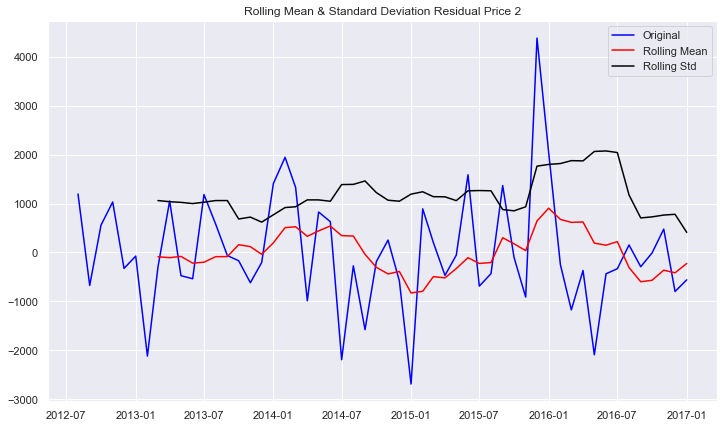

Results of the Dickey-Fuller Test: 

Test Statistic          -6.504260e+00
p-value                  1.141548e-08
#lags Used               0.000000e+00
Number of Observation    5.300000e+01
Critical Value (1%)     -3.560242e+00
Critical Value (5%)     -2.917850e+00
Critical Value (10%)    -2.596796e+00
dtype: float64
None


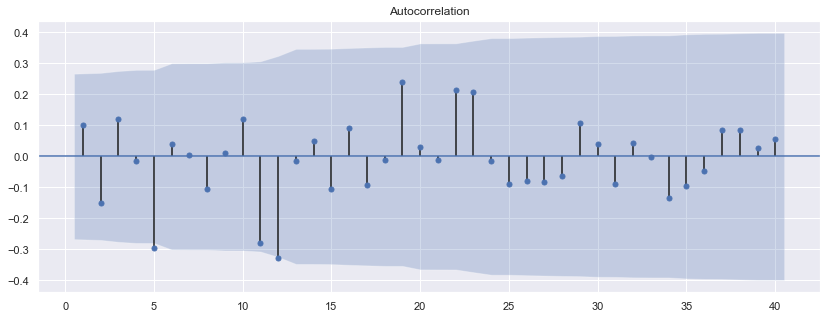

In [101]:
train['residual_price_2'] = residuals_2
print(train.residual_price_2.mean())
print(train.residual_price_2.var())
print(stationarity_check(train.residual_price_2, 'Residual Price 2'))
print(plot_acf(train.residual_price_2, zero=False, lags=40);)


2.412869888869485
1166445.9254658024


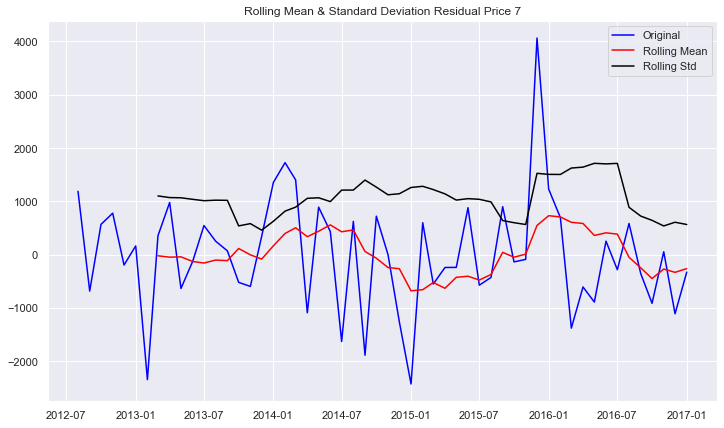

Results of the Dickey-Fuller Test: 

Test Statistic          -6.879661e+00
p-value                  1.444309e-09
#lags Used               0.000000e+00
Number of Observation    5.300000e+01
Critical Value (1%)     -3.560242e+00
Critical Value (5%)     -2.917850e+00
Critical Value (10%)    -2.596796e+00
dtype: float64
None


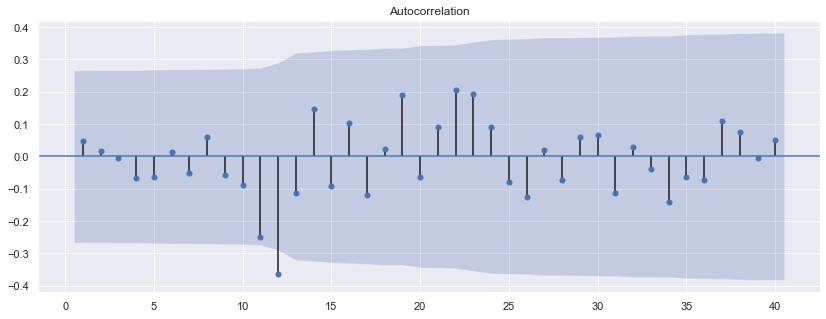

In [107]:
train['residual_price_7'] = residuals_7
print(train.residual_price_7.mean())
print(train.residual_price_7.var())
print(stationarity_check(train.residual_price_7, 'Residual Price 7'))
plot_acf(train.residual_price_7, zero=False, lags=40);

-2.752165296159181
918145.4003325939


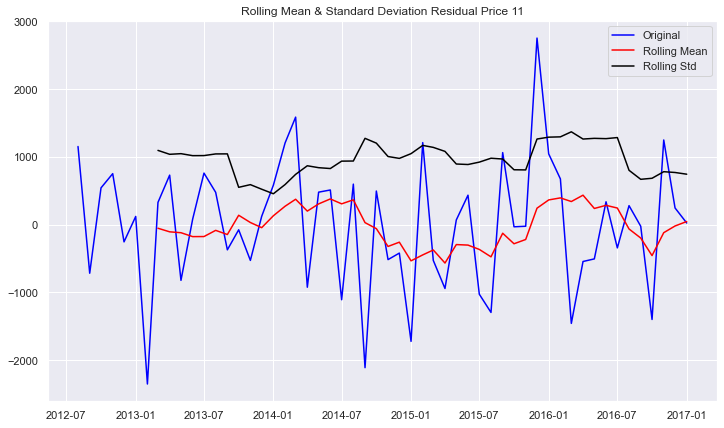

Results of the Dickey-Fuller Test: 

Test Statistic          -8.045759e+00
p-value                  1.796461e-12
#lags Used               0.000000e+00
Number of Observation    5.300000e+01
Critical Value (1%)     -3.560242e+00
Critical Value (5%)     -2.917850e+00
Critical Value (10%)    -2.596796e+00
dtype: float64
None


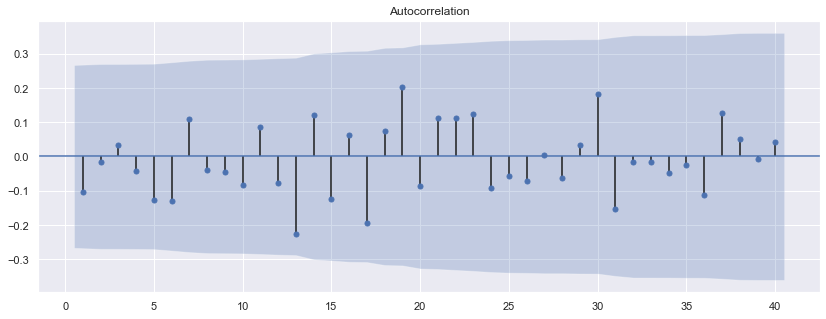

In [108]:
train['residual_price_11'] = residuals_11
print(train.residual_price_11.mean())
print(train.residual_price_11.var())
print(stationarity_check(train.residual_price_11, 'Residual Price 11'))
plot_acf(train.residual_price_11, zero=False, lags=40);

In [110]:
pdq = (11,2,0)
train, test, results = model_fit_ARIMA(df_NJ_HudsonZC[3][start:]['value'], pdq=pdq)

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   54
Model:                ARIMA(11, 2, 0)   Log Likelihood                -447.182
Method:                       css-mle   S.D. of innovations            917.234
Date:                Sun, 11 Apr 2021   AIC                            920.364
Time:                        21:02:58   BIC                            946.221
Sample:                    08-01-2012   HQIC                           930.336
                         - 01-01-2017                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              46.8418     83.921      0.558      0.577    -117.641     211.325
ar.L1.D2.value      0.6370      0.122      5.242      0.000       0.399       0.875
ar.L2.D2.value     -0.7150      

ARIMA model RMSE on train data: 967.76586
ARIMA model RMSE on test data: 13180.86683


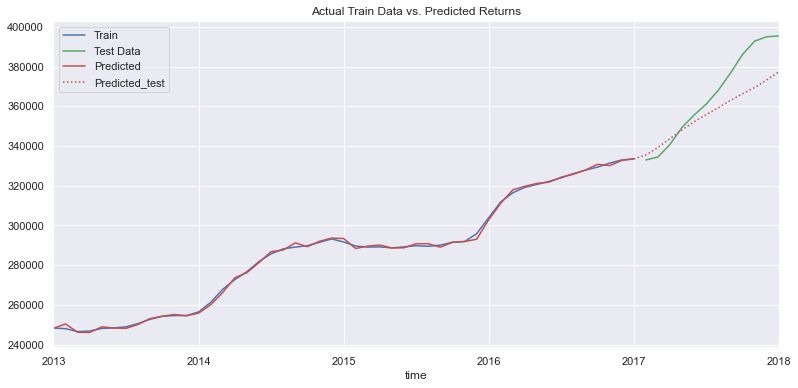

In [111]:
pred_start = datetime(2013,1,1)
pred_end = datetime(2017,1,1)
test_start = datetime(2017,1,1)
test_end = datetime(2018,1,1)

train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred[test_start + timedelta(days=1):test_end]))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

plt.figure(figsize=(13,6))
train[pred_start:pred_end].plot(label='Train',color='b')
test[test_start:test_end].plot(label='Test Data',color='g')
train_pred.plot(label='Predicted',color='r')
test_pred.plot(label='Predicted_test', color='r',ls=':')
plt.legend(loc='best')
plt.title('Actual Train Data vs. Predicted Returns')
plt.show()

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import itertools
d=range(0,3)
q=range(0,7)
p=range(0,1)
pdq = list(itertools.product(p,d,q))

params=[]
aics=[]
LL=[]

for param in pdq:
    try:
        model_arima = ARIMA(train, order=param)
        model_arima_fit = model_arima.fit()
        params.append(param)
        aics.append(model_arima_fit.aic)
        LL.append(model_arima_fit.llf)
        
    except:
        continue
data_param = {'param':params,'AIC':aics, 'LLf':LL}
df_param = pd.DataFrame(data_param)
df_param.sort_values(by='AIC').head()

# MA

In [68]:
import warnings
warnings.filterwarnings('ignore')
import itertools
d=range(0,3)
p=q=range(0,5)
pdq = list(itertools.product(p,d,q))

params=[]
aics=[]
LL=[]

for param in pdq:
    try:
        model_arima = ARIMA(train, order=param)
        model_arima_fit = model_arima.fit()
        params.append(param)
        aics.append(model_arima_fit.aic)
        LL.append(model_arima_fit.llf)
        
    except:
        continue
data_param = {'param':params,'AIC':aics, 'LLf':LL}
df_param = pd.DataFrame(data_param)
df_param.sort_values(by='AIC').head()

,param,AIC,LLf
10,"(0, 2, 3)",912.828567,-451.414284
21,"(1, 2, 3)",914.793278,-451.396639
11,"(0, 2, 4)",914.802122,-451.401061
33,"(2, 2, 3)",915.972075,-450.986037
22,"(1, 2, 4)",916.217625,-451.108813


In [178]:
pdq = (0,2,3)
train, test, results = model_fit_ARIMA(df_NJ_HudsonZC[3][start:]['value'], pdq=pdq)

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   54
Model:                 ARIMA(0, 2, 3)   Log Likelihood                -451.414
Method:                       css-mle   S.D. of innovations            975.854
Date:                Sun, 04 Apr 2021   AIC                            912.829
Time:                        23:25:40   BIC                            922.773
Sample:                    08-01-2012   HQIC                           916.664
                         - 01-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             18.1176     27.614      0.656      0.512     -36.006      72.241
ma.L1.D2.value     0.5995      0.129      4.635      0.000       0.346       0.853
ma.L2.D2.value    -0.6933      0.095

ARIMA model RMSE on train data: 1117.02492
ARIMA model RMSE on test data: 22958.04507


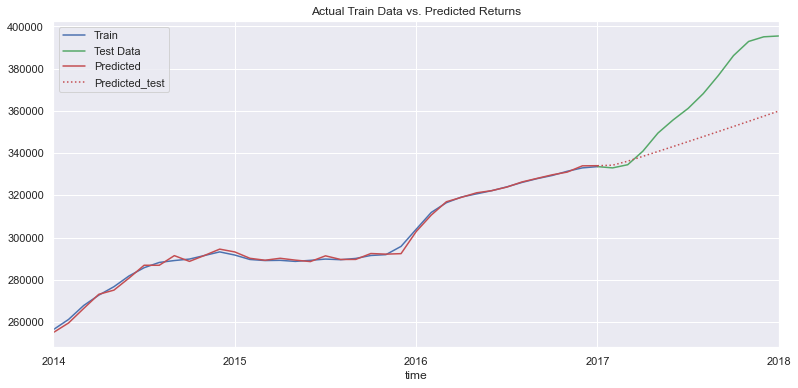

In [179]:
pred_start = datetime(2014,1,1)
pred_end = datetime(2017,1,1)
test_start = datetime(2017,1,1)
test_end = datetime(2018,1,1)

train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

plt.figure(figsize=(13,6))
train[pred_start:pred_end].plot(label='Train',color='b')
test[test_start:test_end].plot(label='Test Data',color='g')
train_pred.plot(label='Predicted',color='r')
test_pred.plot(label='Predicted_test', color='r',ls=':')
plt.legend(loc='best')
plt.title('Actual Train Data vs. Predicted Returns')
plt.show()

# Rolling Forecast Origin 
- In this method we are updating the train data by adding the iterated test data variable (i). 

In [186]:
def model_fit_RFO_ARIMA(df,pdq=(1,0,1)):
    train, test = train_test(df)
    
    predictions_rolling = pd.Series()
    for end_date in test.index:
        train_rolling = df[:end_date - timedelta(days=1)]
        model_arima = ARIMA(train,order=pdq)
        results = model_arima.fit()
        results.summary
        residuals = results.resid
        pred = results.predict(end_date)
        predictions_rolling.loc[end_date] = pred.loc[end_date]
        
    residuals_rolling = test - predictions_rolling
    
    plt.figure(figsize=(10,4))

    plt.plot(test_data)
    plt.plot(predictions_rolling)

    plt.legend(('Test', 'Predictions'), fontsize=16)

    plt.title('3 year predictions (Rolling Forecast Origin)', fontsize=20)
    plt.ylabel('Value', fontsize=20)
    print(results.summary())
    return train, test, results, residuals_rolling, predictions_rolling

In [198]:
train, test = train_test(df_NJ_HudsonZC[3][start:]['value'])
test.index

DatetimeIndex(['2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01',
               '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
               '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01'],
              dtype='datetime64[ns]', name='time', freq='MS')

In [195]:
test.index[0] - timedelta(days=1)

Timestamp('2016-12-31 00:00:00', freq='MS')

In [206]:
def train_test_rof(df):
    pred_start = datetime(2015,1,1)
    pred_end = datetime(2017,1,1)

    # Setting the train data to extend to 1-1-2015
    train = df[:pred_start]
    # Setting the test data to extend to 1-1-2017
    test = df[pred_start + timedelta(days=1):pred_end]
    return train, test

In [211]:
train, test = train_test_rof(df_NJ_HudsonZC[3][start:]['value'])

In [213]:
test

time
2015-02-01    289600.0
2015-03-01    289100.0
2015-04-01    289200.0
2015-05-01    288700.0
2015-06-01    289200.0
2015-07-01    289800.0
2015-08-01    289500.0
2015-09-01    290100.0
2015-10-01    291500.0
2015-11-01    291900.0
2015-12-01    295800.0
2016-01-01    303900.0
2016-02-01    311900.0
2016-03-01    316500.0
2016-04-01    319200.0
2016-05-01    320700.0
2016-06-01    322200.0
2016-07-01    324000.0
2016-08-01    326100.0
2016-09-01    327900.0
2016-10-01    329400.0
2016-11-01    331400.0
2016-12-01    333000.0
2017-01-01    333600.0
Freq: MS, Name: value, dtype: float64

ARIMA model RMSE on train data: 1111.63771


Text(0, 0.5, 'Value')

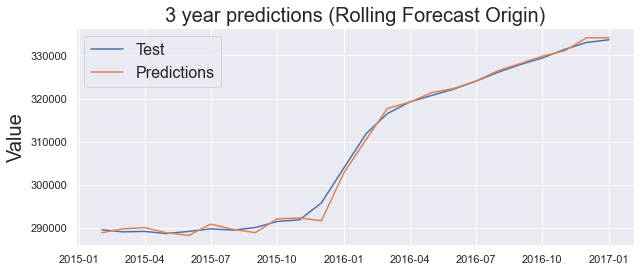

In [215]:
train, test = train_test_rof(df_NJ_HudsonZC[3][start:]['value'])
    
predictions_rolling = pd.Series()
for end_date in test.index:
    train_rolling = df_NJ_HudsonZC[3][start:]['value'][:end_date - timedelta(days=1)]
    model_arima = ARIMA(train_rolling,order=(0,2,3))
    results = model_arima.fit()
    #results.summary
    #residuals = results.resid
    pred = results.predict(end_date, typ='levels')
    predictions_rolling.loc[end_date] = pred.loc[end_date]
        
residuals_rolling = test - predictions_rolling

test_start = datetime(2015,2,1)
test_end = datetime(2017,1,1)

rmse = math.sqrt(mean_squared_error(test[test_start:test_end],predictions_rolling))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
    
plt.figure(figsize=(10,4))

plt.plot(test)
plt.plot(predictions_rolling)

plt.legend(('Test', 'Predictions'), fontsize=16)

plt.title('3 year predictions (Rolling Forecast Origin)', fontsize=20)
plt.ylabel('Value', fontsize=20)




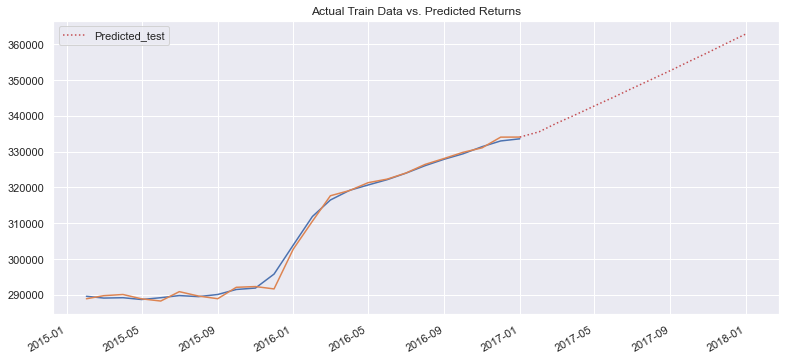

In [217]:
test_start = datetime(2017,1,1)
test_end = datetime(2018,1,1)

test_pred = results.predict(start = test_start, end = test_end, typ='levels')
#rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred))
#print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

plt.figure(figsize=(13,6))
#train[pred_start:pred_end].plot(label='Train',color='b')
#test[test_start:test_end].plot(label='Test Data',color='g')
plt.plot(test)
plt.plot(predictions_rolling)
test[test_start:test_end].plot(label='Test Data',color='g')
test_pred.plot(label='Predicted_test', color='r',ls=':')
plt.legend(loc='best')
plt.title('Actual Train Data vs. Predicted Returns')
plt.show()

In [ ]:
def train_test(df):
    pred_start = datetime(2017,1,1)
    pred_end = datetime(2018,1,1)

    # Setting the train data to extend to 1-1-2017
    train = df[:pred_start]
    # Setting the test data to extend to 1-1-2018
    test = df[pred_start + timedelta(days=1):pred_end]
    return train, test

In [218]:
train, test = train_test(df_NJ_HudsonZC[3][start:]['value'])

In [224]:
results = pm.auto_arima(train,information_criterion='aic',m=12,d=2, 
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=945.153, Time=0.16 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=941.271, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=944.478, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=945.266, Time=0.08 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=944.121, Time=0.03 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=942.774, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=943.062, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=943.908, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=946.083, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=943.271, Time=0.02 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.568 seconds


ARIMA(order=(0, 2, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [221]:
def model_fit_SARIMAX(df,pdq=(0,0,0),PDQS=(0,0,0,0)):
    train, test = train_test(df)
    model = SARIMAX(train,order=pdq,seasonal_order=PDQS)
    results = model.fit()
    results.summary
    residuals = results.resid
    print(results.summary())
    results.plot_diagnostics(figsize=(11,8))
    plt.show();
    return train, test, results

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   56
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -469.636
Date:                Tue, 06 Apr 2021   AIC                            941.271
Time:                        21:51:39   BIC                            943.260
Sample:                    06-01-2012   HQIC                           942.038
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.094e+06   3.37e+05      6.207      0.000    1.43e+06    2.76e+06
Ljung-Box (Q):                      102.63   Jarque-Bera (JB):                 2.74
Prob(Q):                              0.00   Pr

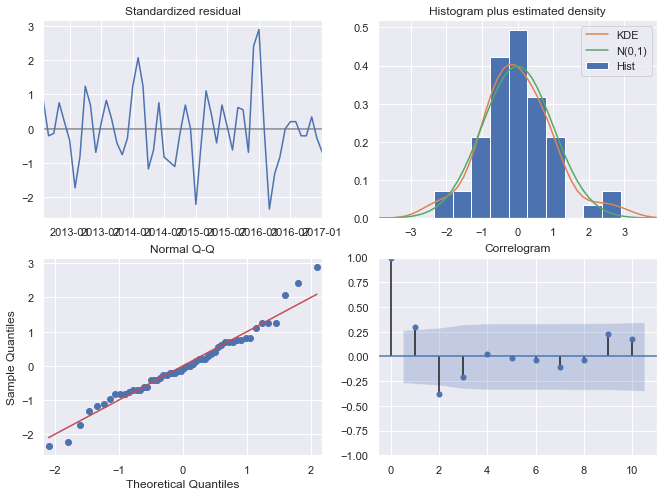

In [230]:
pdq = (0,2,0)
PDQS = (0,0,0,12)
train, test, results = model_fit_SARIMAX(df_NJ_HudsonZC[3][start:]['value'], pdq=pdq, PDQS=PDQS)

ARIMA model RMSE on train data: 1592.38051
ARIMA model RMSE on test data: 34914.64592


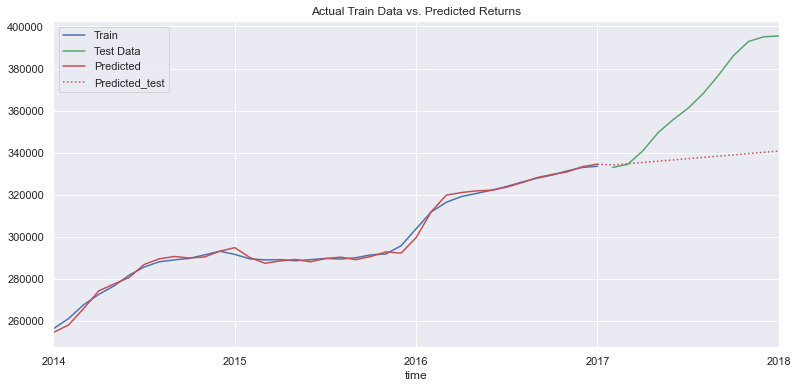

In [238]:
pred_start = datetime(2014,1,1)
pred_end = datetime(2017,1,1)
test_start = datetime(2017,1,1)
test_end = datetime(2018,1,1)

train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred[test_start + timedelta(days=1):test_end]))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

plt.figure(figsize=(13,6))
train[pred_start:pred_end].plot(label='Train',color='b')
test[test_start:test_end].plot(label='Test Data',color='g')
train_pred.plot(label='Predicted',color='r')
test_pred.plot(label='Predicted_test', color='r',ls=':')
plt.legend(loc='best')
plt.title('Actual Train Data vs. Predicted Returns')
plt.show()

In [251]:
def train_test_6m(df, ps, pe):
    pred_start = ps
    pred_end = pe

    # Setting the train data to extend to 6-1-2017
    train = df[:pred_start]
    # Setting the test data to extend to 1-1-2018
    test = df[pred_start + timedelta(days=1):pred_end]
    return train, test

In [252]:
train, test = train_test_6m(df_NJ_HudsonZC[3][start:]['value'],datetime(2017,6,1),datetime(2018,1,1))

In [253]:
results = pm.auto_arima(train,information_criterion='aic',m=12,d=2, 
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1043.847, Time=0.15 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1041.040, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1044.496, Time=0.03 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1045.806, Time=0.04 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1044.589, Time=0.03 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1046.153, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1043.070, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1044.460, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1046.593, Time=0.16 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1042.836, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.527 seconds


ARIMA(order=(0, 2, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [257]:
def model_fit_SARIMAX(df,pdq=(0,0,0),PDQS=(0,0,0,0), ps=datetime(2017,6,1), pe=datetime(2018,1,1)):
    train, test = train_test_6m(df, ps, pe)
    model = SARIMAX(train,order=pdq,seasonal_order=PDQS)
    results = model.fit()
    results.summary
    residuals = results.resid
    print(results.summary())
    results.plot_diagnostics(figsize=(11,8))
    plt.show();
    return train, test, results

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   61
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -519.520
Date:                Wed, 07 Apr 2021   AIC                           1041.040
Time:                        22:18:50   BIC                           1043.118
Sample:                    06-01-2012   HQIC                          1041.851
                         - 06-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.602e+06   3.96e+05      6.566      0.000    1.83e+06    3.38e+06
Ljung-Box (Q):                      117.08   Jarque-Bera (JB):                 4.55
Prob(Q):                              0.00   Pr

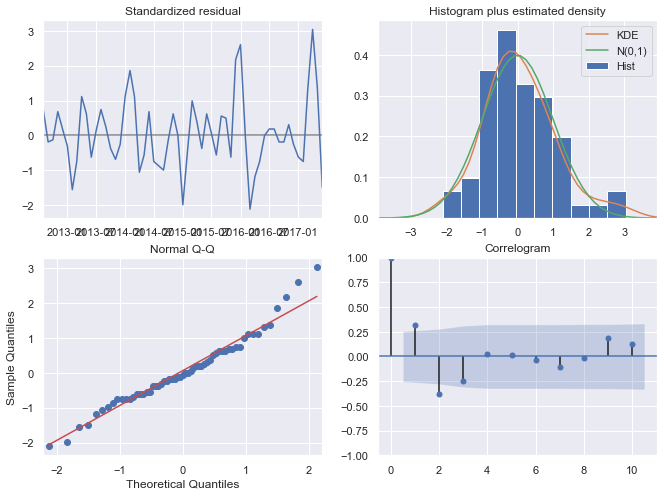

In [258]:
pdq = (0,2,0)
PDQS = (0,0,0,12)
ps=datetime(2017,6,1)
pe=datetime(2018,1,1)
train, test, results = model_fit_SARIMAX(df_NJ_HudsonZC[3][start:]['value'], pdq=pdq, PDQS=PDQS)

ARIMA model RMSE on train data: 1788.05561
ARIMA model RMSE on test data: 3693.23706


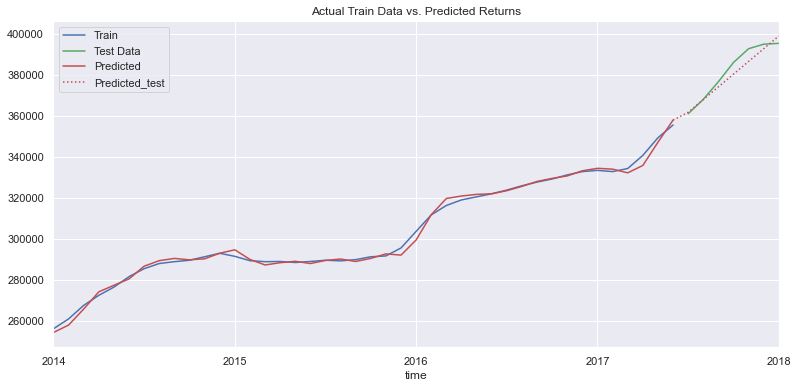

In [259]:
pred_start = datetime(2014,1,1)
pred_end = datetime(2017,6,1)
test_start = datetime(2017,6,1)
test_end = datetime(2018,1,1)

train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred[test_start + timedelta(days=1):test_end]))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

plt.figure(figsize=(13,6))
train[pred_start:pred_end].plot(label='Train',color='b')
test[test_start:test_end].plot(label='Test Data',color='g')
train_pred.plot(label='Predicted',color='r')
test_pred.plot(label='Predicted_test', color='r',ls=':')
plt.legend(loc='best')
plt.title('Actual Train Data vs. Predicted Returns')
plt.show()

In [248]:
df_NJ_HudsonZC[3][start:]['value']

time
2012-06-01    235800.0
2012-07-01    236400.0
2012-08-01    238200.0
2012-09-01    239700.0
2012-10-01    241000.0
                ...   
2017-12-01    395100.0
2018-01-01    395500.0
2018-02-01    399400.0
2018-03-01    407000.0
2018-04-01    412700.0
Freq: MS, Name: value, Length: 71, dtype: float64

In [260]:
train, test = train_test_6m(df_NJ_HudsonZC[3][start:]['value'],datetime(2017,11,1),datetime(2018,4,1))

In [261]:
results = pm.auto_arima(train,information_criterion='aic',m=12,d=2, 
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1132.061, Time=0.22 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1129.173, Time=0.03 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1132.613, Time=0.15 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1133.595, Time=0.09 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1132.722, Time=0.03 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1133.169, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1131.192, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1132.235, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=inf, Time=0.14 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1130.950, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.818 seconds


ARIMA(order=(0, 2, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   66
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -563.587
Date:                Wed, 07 Apr 2021   AIC                           1129.173
Time:                        22:24:19   BIC                           1131.332
Sample:                    06-01-2012   HQIC                          1130.024
                         - 11-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.606e+06   3.92e+05      6.641      0.000    1.84e+06    3.37e+06
Ljung-Box (Q):                      118.90   Jarque-Bera (JB):                 3.28
Prob(Q):                              0.00   Pr

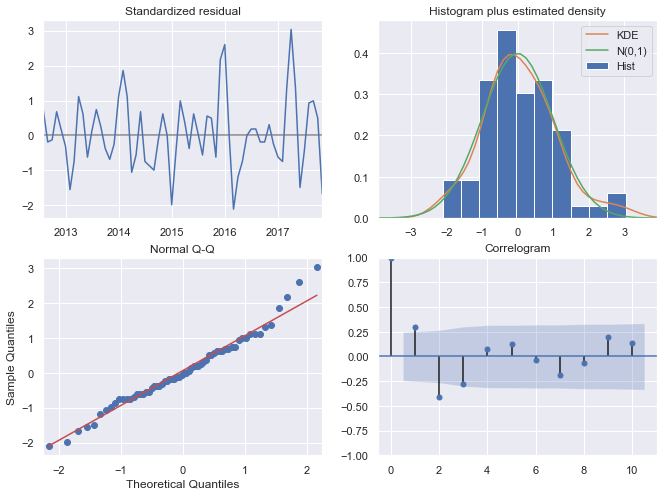

In [262]:
pdq = (0,2,0)
PDQS = (0,0,0,12)
ps=datetime(2017,11,1)
pe=datetime(2018,4,1)
train, test, results = model_fit_SARIMAX(df_NJ_HudsonZC[3][start:]['value'], pdq=pdq, PDQS=PDQS, ps=ps, pe=pe)

ARIMA model RMSE on train data: 1771.58422
ARIMA model RMSE on test data: 11583.00479


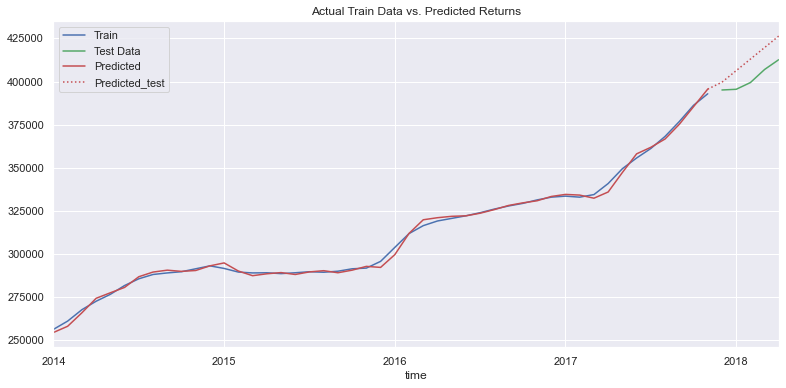

In [263]:
pred_start = datetime(2014,1,1)
pred_end = datetime(2017,11,1)
test_start = datetime(2017,11,1)
test_end = datetime(2018,4,1)

train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred[test_start + timedelta(days=1):test_end]))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

plt.figure(figsize=(13,6))
train[pred_start:pred_end].plot(label='Train',color='b')
test[test_start:test_end].plot(label='Test Data',color='g')
train_pred.plot(label='Predicted',color='r')
test_pred.plot(label='Predicted_test', color='r',ls=':')
plt.legend(loc='best')
plt.title('Actual Train Data vs. Predicted Returns')
plt.show()

In [268]:
train, test = train_test_6m(df_NJ_HudsonZC[3][start:]['value'],datetime(2017,12,1),datetime(2018,4,1))

In [269]:
results = pm.auto_arima(train,information_criterion='aic',m=12,d=2, 
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1156.760, Time=0.28 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1153.220, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1157.043, Time=0.11 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1155.751, Time=0.04 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=inf, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1155.568, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1157.453, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1156.908, Time=0.19 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1155.206, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.861 seconds


ARIMA(order=(0, 2, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   67
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -575.610
Date:                Wed, 07 Apr 2021   AIC                           1153.220
Time:                        22:37:53   BIC                           1155.394
Sample:                    06-01-2012   HQIC                          1154.078
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.877e+06   4.27e+05      6.741      0.000    2.04e+06    3.71e+06
Ljung-Box (Q):                      100.90   Jarque-Bera (JB):                 2.08
Prob(Q):                              0.00   Pr

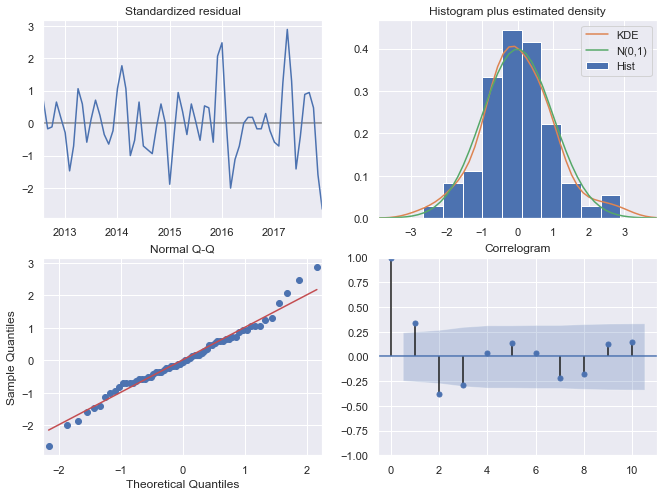

In [270]:
pdq = (0,2,0)
PDQS = (0,0,0,12)
ps=datetime(2017,12,1)
pe=datetime(2018,4,1)
train, test, results = model_fit_SARIMAX(df_NJ_HudsonZC[3][start:]['value'], pdq=pdq, PDQS=PDQS, ps=ps, pe=pe)

ARIMA model RMSE on train data: 1869.49191
ARIMA model RMSE on test data: 5214.88255


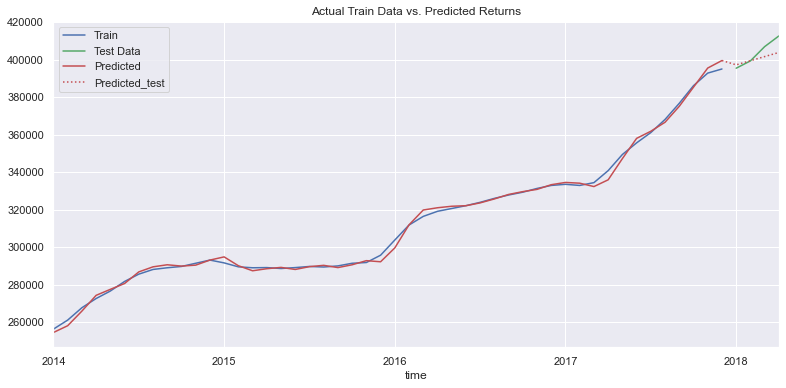

In [271]:
pred_start = datetime(2014,1,1)
pred_end = datetime(2017,12,1)
test_start = datetime(2017,12,1)
test_end = datetime(2018,4,1)

train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred[test_start + timedelta(days=1):test_end]))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

plt.figure(figsize=(13,6))
train[pred_start:pred_end].plot(label='Train',color='b')
test[test_start:test_end].plot(label='Test Data',color='g')
train_pred.plot(label='Predicted',color='r')
test_pred.plot(label='Predicted_test', color='r',ls=':')
plt.legend(loc='best')
plt.title('Actual Train Data vs. Predicted Returns')
plt.show()

In [278]:
train, test = train_test_6m(df_NJ_HudsonZC[3][start:]['value'],datetime(2018,3,1),datetime(2018,4,1))

In [279]:
results = pm.auto_arima(train,information_criterion='aic',m=12,d=2, 
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1216.366, Time=0.44 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1213.136, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1217.243, Time=0.03 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1218.668, Time=0.05 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1214.910, Time=0.05 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1219.690, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1215.693, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1217.164, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=inf, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1214.909, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.794 seconds


ARIMA(order=(0, 2, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   70
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -605.568
Date:                Wed, 07 Apr 2021   AIC                           1213.136
Time:                        22:51:25   BIC                           1215.356
Sample:                    06-01-2012   HQIC                          1214.015
                         - 03-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.179e+06    4.9e+05      6.491      0.000    2.22e+06    4.14e+06
Ljung-Box (Q):                       85.74   Jarque-Bera (JB):                 1.23
Prob(Q):                              0.00   Pr

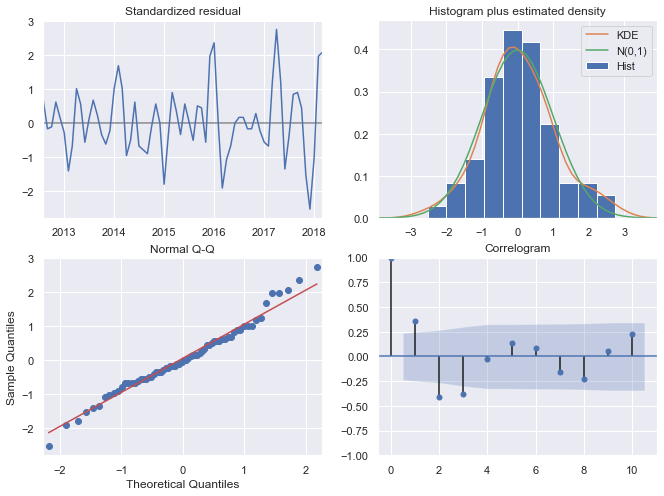

In [280]:
pdq = (0,2,0)
PDQS = (0,0,0,12)
ps=datetime(2018,3,1)
pe=datetime(2018,4,1)
train, test, results = model_fit_SARIMAX(df_NJ_HudsonZC[3][start:]['value'], pdq=pdq, PDQS=PDQS, ps=ps, pe=pe)

ARIMA model RMSE on train data: 1965.08744


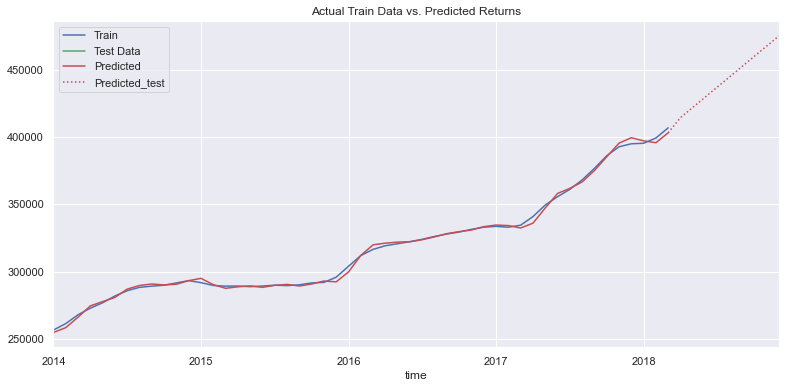

In [281]:
pred_start = datetime(2014,1,1)
pred_end = datetime(2018,3,1)
test_start = datetime(2018,3,1)
test_end = datetime(2018,12,1)

train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
#rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred[test_start + timedelta(days=1):test_end]))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
#print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

plt.figure(figsize=(13,6))
train[pred_start:pred_end].plot(label='Train',color='b')
test[test_start:test_end].plot(label='Test Data',color='g')
train_pred.plot(label='Predicted',color='r')
test_pred.plot(label='Predicted_test', color='r',ls=':')
plt.legend(loc='best')
plt.title('Actual Train Data vs. Predicted Returns')
plt.show()

In [282]:
test_pred

2018-03-01    403300.0
2018-04-01    414600.0
2018-05-01    422200.0
2018-06-01    429800.0
2018-07-01    437400.0
2018-08-01    445000.0
2018-09-01    452600.0
2018-10-01    460200.0
2018-11-01    467800.0
2018-12-01    475400.0
Freq: MS, dtype: float64

In [ ]:
# Do the forecasting part
# understand forcast
